# Problem Statement

Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs. You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs. The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation.

# Team Name, Members, Organization

Team - MLogging

Members:

Jamiu Ekundayo - Curtin University

Partha Pratim Mandal - Curtin University

Subhadeep Sarkar - Schlumberger

# Data loading and Quality check

Import libraies, statistical and visualization
Load training and Test data as pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline


In [2]:
# Load both wells including training (w1) and test (w2)
w1 = pd.read_csv('train.csv')
w2 = pd.read_csv('test.csv')

In [3]:
# Basic statistical check including additional 1, 5 and 95, 99 percentiles - training well: w1
w1.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
1%,-999.000000,-999.000000,1.897624,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
5%,6.044200,0.054300,5.346520,0.340000,0.345000,0.039710,2.087210,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
95%,11.814600,0.548600,124.377000,7.995610,8.011930,14.469290,2.621700,132.623120,349.395450


In [4]:
#Basic statistical check including additional 1, 5, 95 and 99 percentiles - test well: w2
w2.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400
1%,8.546900,0.044587,2.151664,0.309800,0.291887,4.883087,2.140461
5%,8.546900,0.056635,3.284235,0.398700,0.353315,5.033805,2.181035
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800
95%,8.703100,0.349265,77.989050,8.986000,10.008990,8.519230,2.621900


Train well "w1" contains several missing data points (-999.00) in each log while Test well "w2" does not contain any missing data.

In [5]:
# replacing non recording values as nan in w1
w1 = w1.replace(-999.000, np.nan)

In [6]:
# check number of nan in the datafile using for loop
for i in w1.columns:
    print(i, w1[i].isnull().values.any())
print(w1.isnull().sum())

CAL True
CNC True
GR True
HRD True
HRM True
PE True
ZDEN True
DTC True
DTS True
CAL      510
CNC      735
GR       254
HRD      385
HRM      385
PE       679
ZDEN     681
DTC     4054
DTS     4865
dtype: int64


In [7]:
# check number of nan in the datafile using for loop - Test well "W2"
for i in w2.columns:
    print(i, w2[i].isnull().values.any())
print(w2.isnull().sum())

CAL False
CNC False
GR False
HRD False
HRM False
PE False
ZDEN False
CAL     0
CNC     0
GR      0
HRD     0
HRM     0
PE      0
ZDEN    0
dtype: int64


In [8]:
# drop all nan values from train well - w1
w1.dropna(axis=0, inplace=True)

Check agin the statistical distribution of w1 after remvoing all nan values

In [9]:
#After droping nan values
# Basic statistical check including additional 1, 5 and 95, 99 percentiles - training well: w1
w1.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000
mean,8.426679,0.274416,49.889253,2.598719,5.835466,3.833792,2.410734,88.312221,182.051067
std,1.845912,3.062495,54.811017,3.465665,422.449589,4.375818,0.181713,23.542419,84.670122
min,5.930400,0.014500,1.038900,0.123600,0.134100,-0.023200,0.680600,49.970500,80.580400
1%,5.984600,0.043100,2.893680,0.266748,0.285048,0.028500,2.064472,57.900792,105.399428
5%,6.047360,0.059000,4.971240,0.343220,0.346920,0.041100,2.124600,61.015060,111.773880
25%,6.629100,0.120300,16.036800,0.810000,0.797300,0.049800,2.236100,70.423100,127.148800
50%,8.578100,0.187700,37.498000,1.814900,1.829300,3.287800,2.466500,79.695400,142.678500
75%,8.671900,0.329000,61.140700,3.337400,3.463300,7.061300,2.563700,102.482800,192.757800
95%,11.907540,0.554200,134.566300,7.642440,7.597060,11.212060,2.627300,133.109920,389.089240


Significant reduction of number of data points because of non recording values

Still we can see unusual maximum values of different logs like CNC, GR, HRM, PE etc. May require further data cleaning

In [10]:
# Number of logs on training data
w1.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS'], dtype='object')

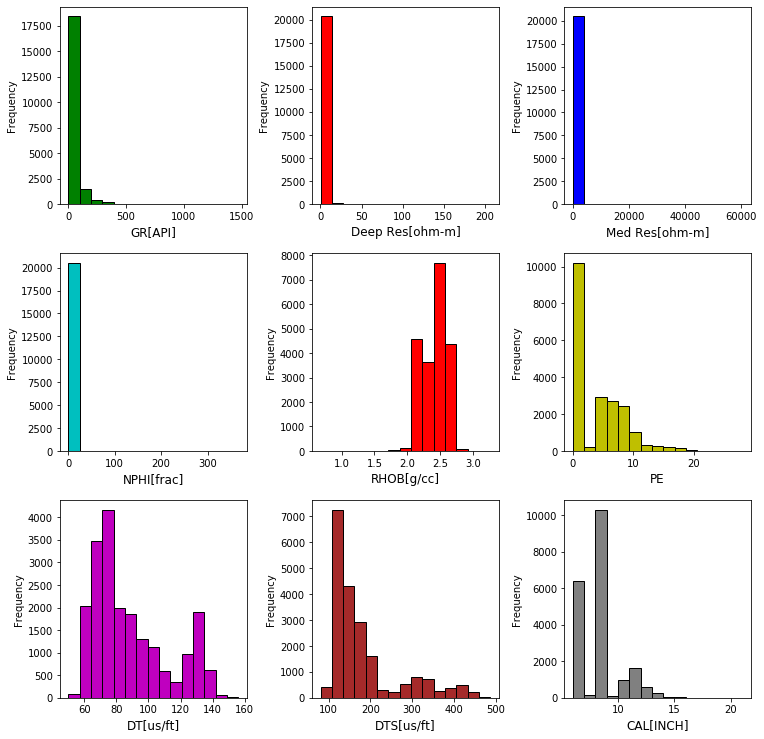

In [11]:
# Plot histogram of each logs
# Histogram plot of W1 well

logs=w1.copy()
plt.figure(figsize=(12,12))
plt.subplot(331)
plt.hist(logs.GR.dropna(), bins=15, color='g', edgecolor='k')
plt.xlabel('GR[API]', fontsize=12)
plt.ylabel('Frequency')
#plt.xlim(0,150)
#plt.grid(True)

plt.subplot(332)
plt.hist(logs.HRD.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('Deep Res[ohm-m]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(333)
plt.hist(logs.HRM.dropna(), bins=15, color='b', edgecolor='k')
plt.xlabel('Med Res[ohm-m]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(334)
plt.hist(logs.CNC.dropna(), bins=15, color='c', edgecolor='k')
plt.xlabel('NPHI[frac]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(335)
plt.hist(logs.ZDEN.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('RHOB[g/cc]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(336)
plt.hist(logs.PE.dropna(), bins=15, color='y', edgecolor='k')
plt.xlabel('PE',fontsize=12)
plt.ylabel('Frequency')
#plt.xlim(0,150)
#plt.grid(True)

plt.subplot(337)
plt.hist(logs.DTC.dropna(), bins=15, color='m', edgecolor='k')
plt.xlabel('DT[us/ft]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(338)
plt.hist(logs.DTS.dropna(), bins=15, color='brown', edgecolor='k')
plt.xlabel('DTS[us/ft]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(339)
plt.hist(logs.CAL.dropna(), bins=15, color='grey', edgecolor='k')
plt.xlabel('CAL[INCH]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)
plt.subplots_adjust(top=0.9, bottom=.1, left=0.10, right=0.9, hspace=0.25, wspace=0.35)

In [12]:
# Check index range after droping nan values
w1.index

Int64Index([  573,   574,   575,   576,   577,   578,   579,   580,   581,
              582,
            ...
            30133, 30134, 30135, 30136, 30137, 30138, 30139, 30140, 30141,
            30142],
           dtype='int64', length=20525)

In [13]:
# reset index of pandas dataframe to start from zero
w1.reset_index(drop=True, inplace=True)

In [14]:
# revised index of w1 dataset
w1.index

RangeIndex(start=0, stop=20525, step=1)

# Triple Combo Log plot

In [15]:
# call the triple combo log function as defined
def triple_combo_log(data,top_depth,bottom_depth):
    
    logs=w1[(w1.index >= top_depth) & (w1.index <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15), sharey=True)
    fig.suptitle("Triple-combo Log display data", fontsize=16)
    fig.subplots_adjust(top=0.85,wspace=0.1)
    
# setting for all axes
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False)
        
# First track GR, CALI, PE logs to display
        ax1 = ax[0].twiny()
        ax1.set_xlim(0,16)
        ax1.spines['top'].set_position(('outward',0))
        ax1.plot(logs.PE, logs.index, '-b', label= "PE")
        ax1.set_xlabel('PE',color='b')    
        ax1.tick_params(axis='x', colors='b')
        ax1.grid(True)
        
        ax2 = ax[0].twiny()
        ax2.set_xlim(0, 16)
        ax2.spines['top'].set_position(('outward', 40))
        ax2.plot(logs.CAL, logs.index, '--k', label= "CALI (in)")
        ax2.set_xlabel('CALI(in)', color ='k')
        ax2.tick_params(axis='x', colors='k')
        
        ax3 = ax[0].twiny()
        ax3.set_xlim(0,300)
        ax3.spines['top'].set_position(('outward', 80))
        ax3.plot(logs.GR, logs.index, '-g', label= "GR (API)")
        ax3.set_xlabel('GR(API)', color= 'g')
        ax3.tick_params(axis='x', colors='g')
        

# Second track resitivity plot
        ax11 = ax[1].twiny()
        ax11.set_xlim(0.1, 1000)
        ax11.set_xscale('log')
        ax11.grid(True)
        ax11.spines['top'].set_position(('outward', 0))
        ax11.plot(logs.HRD, logs.index, '-r', label="HRD (m.ohm)")
        ax11.set_xlabel('HRD(m.ohm)', color = 'r')
        ax11.tick_params(axis='x', colors='r')
        
         
        ax12 = ax[1].twiny()
        ax12.set_xlim(0.1, 1000)
        ax12.set_xscale('log')
        ax12.spines['top'].set_position(('outward', 40))
        ax12.plot(logs.HRM, logs.index, '-m', label= "HRM (m.ohm)")
        ax12.set_xlabel('HRM(m.ohm)', color= 'm')
        ax12.tick_params(axis='x', colors='m')
         
# Third track NPHI, RHO, DT display
        ax21 = ax[2].twiny()
        ax21.grid(True)
        ax21.set_xlim(140,40)
        ax21.spines['top'].set_position(('outward', 0))
        ax21.plot(logs.DTC, logs.index, '-b', label= "DT (us/ft)")
        ax21.set_xlabel('DT(us/ft)', color= 'b')
        ax21.tick_params(axis='x', colors= 'b')

        
        ax22 = ax[2].twiny()
        #ax22.grid(True)
        ax22.set_xlim(440,100)
        ax22.spines['top'].set_position(('outward', 40))
        ax22.plot(logs.DTS, logs.index, '-r', label= "DTS (us/ft)")
        ax22.set_xlabel('DTS(us/ft)', color= 'r')
        ax22.tick_params(axis='x', colors= 'r')        
         
        ax23 = ax[3].twiny()
        ax23.grid(True)
        ax23.set_xlim(0, .6)
        ax23.invert_xaxis()
        ax23.spines['top'].set_position(('outward', 0))
        ax23.plot(logs.CNC, logs.index, '--k', label = "NPHI (%)")
        ax23.set_xlabel('NPHI(frac)', color = 'k')
        ax23.tick_params(axis= 'x', colors='k')
         
        ax24 = ax[3].twiny()
        ax24.set_xlim(1.5, 3.0)
        ax24.spines['top'].set_position(('outward', 40))
        ax24.plot(logs.ZDEN, logs.index, '-r', label= "RHOB (g/cc)")
        ax24.set_xlabel('RHOB(g/cc)', color = 'r')
        ax24.tick_params(axis='x', colors= 'r')

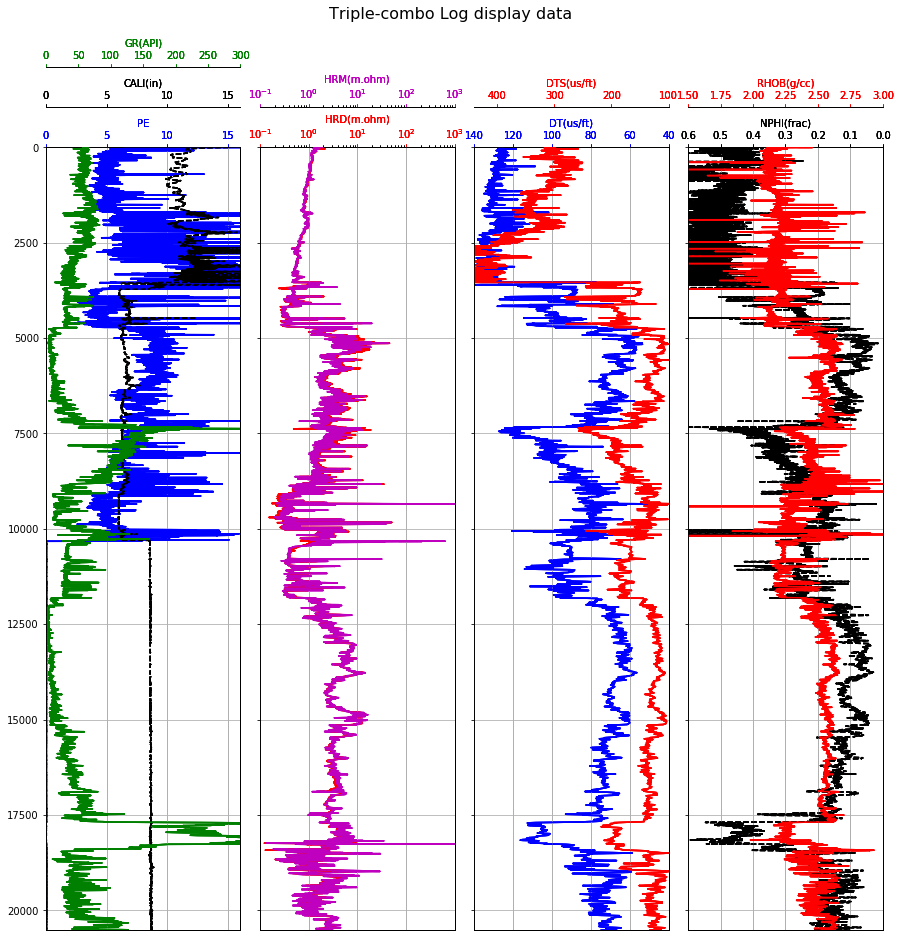

In [16]:
triple_combo_log(w1,w1.index.min(), w1.index.max())

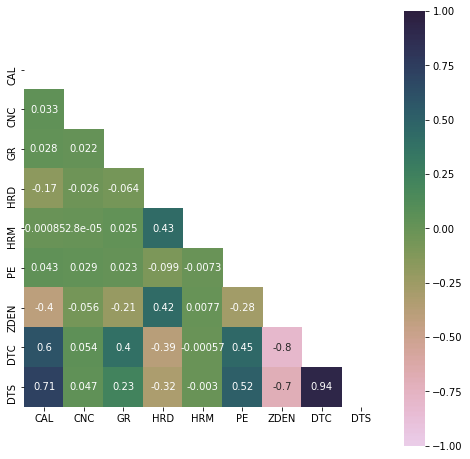

In [17]:
# Generate heat map 
# Generate a mask for upper traingle

mask = np.zeros_like(logs.corr(method='pearson'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a color map
cmap = sns.cubehelix_palette(n_colors=12, start = -2.25, rot= -1.3, as_cmap=True)

# Draw a heatmap
plt.figure(figsize=(8,8))
sns.heatmap(logs.corr(method='pearson'), annot = True, mask=mask, cmap =cmap, vmin=-1.0, vmax=1.0, square=True)
plt.show()

(-1, 1)

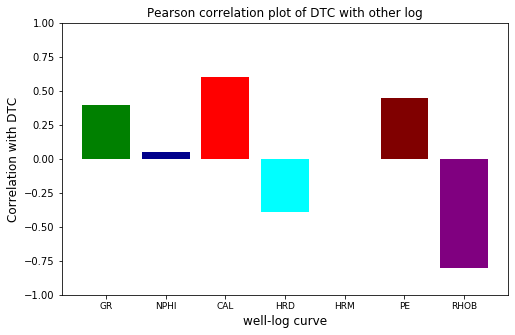

In [18]:
#Bar chart of correlation for DTC curve
label = ['GR', 'NPHI', 'CAL', 'HRD', 'HRM', 'PE','RHOB']
correlation = [0.4, 0.054,0.6,-0.39, -0.001,0.45, -0.8]
clr = ['green','darkblue','red','cyan', 'yellow', 'maroon','purple']

index = np.arange(len(label))
plt.figure(figsize=(8,5))
plt.bar(index, correlation, color=clr)
plt.xlabel('well-log curve', fontsize=12)
plt.ylabel('Correlation with DTC', fontsize=12)
plt.xticks(index,label, fontsize=9)
plt.title('Pearson correlation plot of DTC with other log')
plt.ylim(-1,1)

(-1, 1)

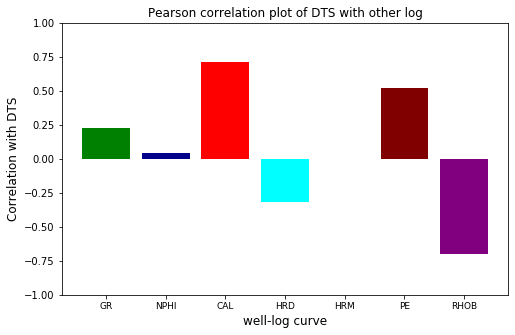

In [19]:
#Bar chart of correlation for DTS curve
label = ['GR', 'NPHI', 'CAL', 'HRD', 'HRM', 'PE','RHOB']
correlation = [0.23, 0.047,0.71, -0.32, -0.003,0.52, -0.7]
clr = ['green','darkblue','red','cyan', 'yellow', 'maroon','purple']

index = np.arange(len(label))
plt.figure(figsize=(8,5))
plt.bar(index, correlation, color=clr)
plt.xlabel('well-log curve', fontsize=12)
plt.ylabel('Correlation with DTS', fontsize=12)
plt.xticks(index,label, fontsize=9)
plt.title('Pearson correlation plot of DTS with other log')
plt.ylim(-1,1)

# Similarity Analysis - Petrophysical similarity

In [20]:
# use cosine similarity index between each log curves with DTC 
from sklearn.metrics.pairwise import cosine_similarity
print('Similarity between GR and DTC', cosine_similarity(w1.GR.values.reshape(1,-1), w1.DTC.values.reshape(1,-1)))
print('Similarity between CAL and DTC',cosine_similarity(w1.CAL.values.reshape(1,-1), w1.DTC.values.reshape(1,-1)))
print('Similarity between NPHI and DTC',cosine_similarity(w1.CNC.values.reshape(1,-1), w1.DTC.values.reshape(1,-1)))
print('Similarity between Deep Res and DTC',cosine_similarity(w1.HRD.values.reshape(1,-1), w1.DTC.values.reshape(1,-1)))
print('Similarity between Med Res and DTC',cosine_similarity(w1.HRM.values.reshape(1,-1), w1.DTC.values.reshape(1,-1)))
print('Similarity between PE and DTC',cosine_similarity(w1.PE.values.reshape(1,-1), w1.DTC.values.reshape(1,-1)))
print('Similarity between RHOB and DTC',cosine_similarity(w1.ZDEN.values.reshape(1,-1), w1.DTC.values.reshape(1,-1)))

Similarity between GR and DTC [[0.72614173]]
Similarity between CAL and DTC [[0.97668567]]
Similarity between NPHI and DTC [[0.10008155]]
Similarity between Deep Res and DTC [[0.49949238]]
Similarity between Med Res and DTC [[0.01319951]]
Similarity between PE and DTC [[0.72378702]]
Similarity between RHOB and DTC [[0.94800242]]


In [21]:
# use cosine similarity index between each log curves with DTS
print('Similarity between GR and DTS', cosine_similarity(w1.GR.values.reshape(1,-1), w1.DTS.values.reshape(1,-1)))
print('Similarity between CAL and DTS',cosine_similarity(w1.CAL.values.reshape(1,-1), w1.DTS.values.reshape(1,-1)))
print('Similarity between NPHI and DTS',cosine_similarity(w1.CNC.values.reshape(1,-1), w1.DTS.values.reshape(1,-1)))
print('Similarity between Deep Res and DTS',cosine_similarity(w1.HRD.values.reshape(1,-1), w1.DTS.values.reshape(1,-1)))
print('Similarity between Med Res and DTS',cosine_similarity(w1.HRM.values.reshape(1,-1), w1.DTS.values.reshape(1,-1)))
print('Similarity between PE and DTS',cosine_similarity(w1.PE.values.reshape(1,-1), w1.DTS.values.reshape(1,-1)))
print('Similarity between RHOB and DTS',cosine_similarity(w1.ZDEN.values.reshape(1,-1), w1.DTS.values.reshape(1,-1)))

Similarity between GR and DTS [[0.68323294]]
Similarity between CAL and DTS [[0.95009089]]
Similarity between NPHI and DTS [[0.10052877]]
Similarity between Deep Res and DTS [[0.43689649]]
Similarity between Med Res and DTS [[0.01126397]]
Similarity between PE and DTS [[0.76303319]]
Similarity between RHOB and DTS [[0.88212345]]


# Anomaly detection with ML technique on Training data

Because of the condition of the competation we could not apply anomaly detection on test data, but we feel this is necessary to improve the prediction.
After looking all petrophysical logs, we realise the major concern relates to ZDEN and CNC log curves as several spike is visible which either arises from poor borehole condition or tool limitations. 

Sudden change of GR response indicate changing lithology which may not be indication of anomaly. However PE log is not acceptable in this well as values are far beyond the useable range. Caliper log acts as axualiary log which provides borehole diamter and it would help quality control of log data (Petrophysical point of view). Therefore flagging of anomalous datapoints based on ZDEN and CNC response with ML technique.

In [22]:
# import svm one class
from sklearn import svm
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
# Isolation forest
from sklearn.ensemble import IsolationForest
# create a copy of training data
training_data=w1.copy()

In [23]:
# drop columns , only keep ZDEN and CNC log for anomoly identification
train_data= training_data.drop(columns=['CAL','GR', 'HRM','HRD', 'PE', 'DTC', 'DTS'], axis=1)

After running both SVM once class and Isolation forest method, our observation is that isolation forest better flag anomaly compared to svm. So we are showing Isolation forest application. Selection of contamination based upon trial and error approach. We found 6% is optimum in present scenario.

In [24]:
# Isolation forest, major parameter percentage of outlier present with parameter contaminatio, nu : 6 %
isf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.06),
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=100, verbose=0)
isf.fit(train_data)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.06,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=100, verbose=0, warm_start=False)

In [25]:
# Automatic anomoly flagging by application of the model on whole training data sample
pred = isf.predict(train_data)
# inliers are labeled 1, outliers are labeled -1

train_data['anomaly_isf']=pred

outliers=train_data.loc[train_data['anomaly_isf']==-1]
outlier_index=list(outliers.index)

#Find the number of anomalies and normal points here points classified -1 are anomalous

print('IsolationForest anamaly detection',train_data['anomaly_isf'].value_counts())

IsolationForest anamaly detection  1    19293
-1     1232
Name: anomaly_isf, dtype: int64


(20600, 0)

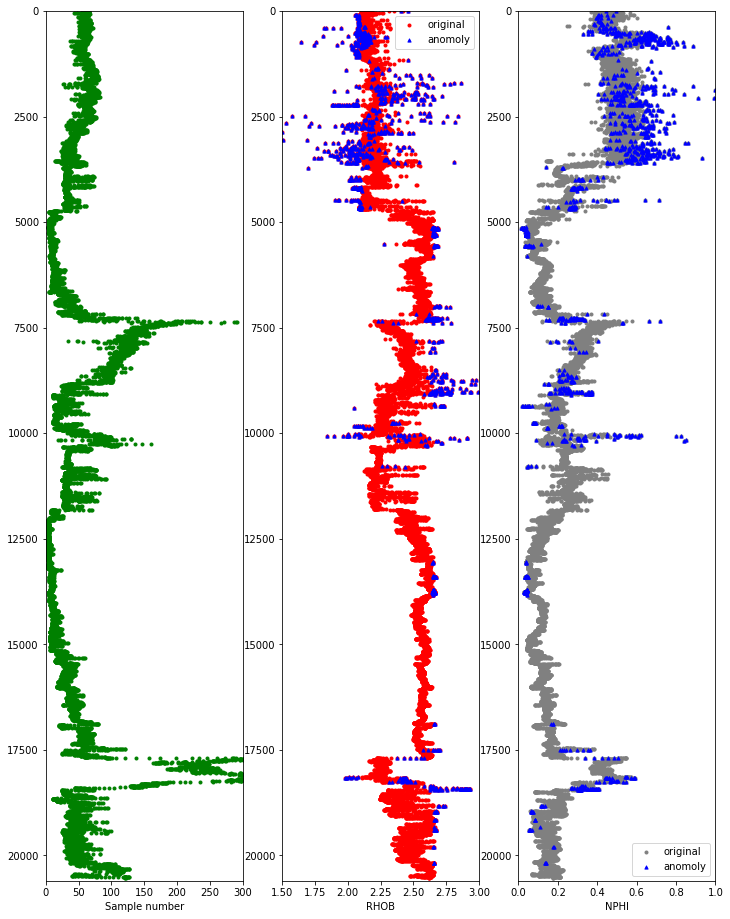

In [26]:
# Plot anomolous datapoint along with original data
plt.figure(figsize=(12,16))
plt.subplot(131)
plt.scatter(training_data.GR, training_data.index, marker='.',color='g')
plt.xlim(0,300)
plt.xlabel('GR')
plt.xlabel('Sample number')
plt.ylim(20600,0)

plt.subplot(132)
plt.scatter(train_data.ZDEN, train_data.index, marker='.',color='r', label='original')
plt.scatter(outliers.ZDEN,outliers.index, marker='^', color='b', s=10, label='anomoly')
plt.xlim(1.5,3.0)
plt.xlabel('RHOB')
plt.legend()
plt.ylim(20600,0)

plt.subplot(133)
plt.scatter(train_data.CNC, train_data.index, marker='.',color='grey',label='original')
plt.scatter(outliers.CNC,outliers.index, marker='^', color='b',s=10, label='anomoly')
plt.xlim(0,1)
plt.xlabel('NPHI')
plt.legend()
plt.ylim(20600,0)

In [27]:
# add anomoly flag to original dataset - training_data
training_data['anomaly_isf']=train_data.anomaly_isf

In [28]:
# discard flagged anomoly datapoints and check statistics
training_data=training_data[training_data.anomaly_isf==1]
training_data.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,anomaly_isf
count,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.0
mean,8.357259,0.230194,49.283807,2.547563,2.704499,3.567083,2.415621,87.212337,177.737553,1.0
std,1.748542,0.148991,52.960473,2.551030,6.722277,4.145705,0.167015,22.815320,81.024963,0.0
min,5.930400,0.026400,1.038900,0.123600,0.134100,-0.023200,2.083700,53.477300,83.636800,1.0
25%,6.633100,0.118900,15.331200,0.819500,0.804300,0.049400,2.242900,70.201600,126.762600,1.0
50%,8.578100,0.181500,36.748500,1.932100,1.941100,0.069100,2.470300,78.629400,141.136700,1.0
75%,8.625000,0.306000,60.723200,3.370700,3.496700,6.869900,2.562100,99.595700,189.183900,1.0
max,21.064200,0.642300,1304.289800,89.479200,637.878300,27.943200,2.661100,155.980300,487.438400,1.0


In [29]:
# re-indexing
training_data.reset_index(drop=True, inplace=True)

# Test data check

In [30]:
#Basic statistical check including additional 1, 5, 95 and 99 percentiles - test well: w2
w2.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400
1%,8.546900,0.044587,2.151664,0.309800,0.291887,4.883087,2.140461
5%,8.546900,0.056635,3.284235,0.398700,0.353315,5.033805,2.181035
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800
95%,8.703100,0.349265,77.989050,8.986000,10.008990,8.519230,2.621900


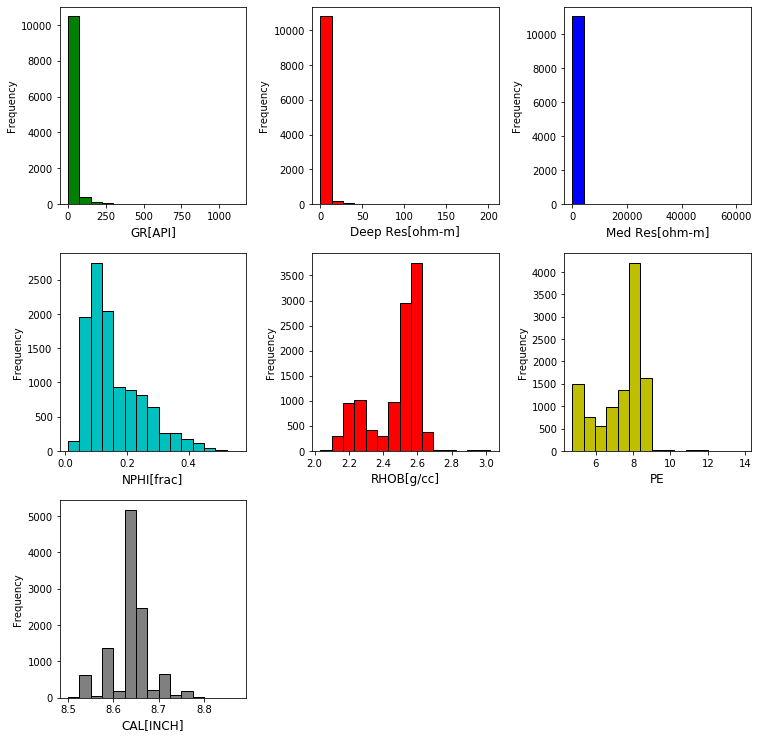

In [31]:
# Plot histogram of each logs
# Histogram plot of W2 well
logs=w2.copy()
plt.figure(figsize=(12,12))
plt.subplot(331)
plt.hist(logs.GR.dropna(), bins=15, color='g', edgecolor='k')
plt.xlabel('GR[API]', fontsize=12)
plt.ylabel('Frequency')
#plt.xlim(0,150)
#plt.grid(True)

plt.subplot(332)
plt.hist(logs.HRD.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('Deep Res[ohm-m]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(333)
plt.hist(logs.HRM.dropna(), bins=15, color='b', edgecolor='k')
plt.xlabel('Med Res[ohm-m]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(334)
plt.hist(logs.CNC.dropna(), bins=15, color='c', edgecolor='k')
plt.xlabel('NPHI[frac]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(335)
plt.hist(logs.ZDEN.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('RHOB[g/cc]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(336)
plt.hist(logs.PE.dropna(), bins=15, color='y', edgecolor='k')
plt.xlabel('PE',fontsize=12)
plt.ylabel('Frequency')
#plt.xlim(0,150)
#plt.grid(True)


plt.subplot(337)
plt.hist(logs.CAL.dropna(), bins=15, color='grey', edgecolor='k')
plt.xlabel('CAL[INCH]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)
plt.subplots_adjust(top=0.9, bottom=.1, left=0.10, right=0.9, hspace=0.25, wspace=0.35)

In [32]:
# call the triple combo function as defined
def triple_combo_log1(data,top_depth,bottom_depth):
    
    logs=w2[(w2.index >= top_depth) & (w2.index <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,15), sharey=True)
    fig.suptitle("Triple-combo Log display w2 ", fontsize=16)
    fig.subplots_adjust(top=0.85,wspace=0.1)
    
# setting for all axes
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False)

#First track GR, CALI, PE logs to display
        ax1 = ax[0].twiny()
        ax1.set_xlim(0,16)
        ax1.spines['top'].set_position(('outward',0))
        ax1.plot(logs.PE, logs.index, '-b', label= "PE")
        ax1.set_xlabel('PE',color='b')    
        ax1.tick_params(axis='x', colors='b')
        ax1.grid(True)
        
        ax2 = ax[0].twiny()
        ax2.set_xlim(0, 16)
        ax2.spines['top'].set_position(('outward', 40))
        ax2.plot(logs.CAL, logs.index, '--k', label= "CALI (in)")
        ax2.set_xlabel('CALI(in)', color ='k')
        ax2.tick_params(axis='x', colors='k')
        
        ax3 = ax[0].twiny()
        ax3.set_xlim(0,300)
        ax3.spines['top'].set_position(('outward', 80))
        ax3.plot(logs.GR, logs.index, '-g', label= "GR (API)")
        ax3.set_xlabel('GR(API)', color= 'g')
        ax3.tick_params(axis='x', colors='g')
        

# Second track resitivity plot
        ax11 = ax[1].twiny()
        ax11.set_xlim(0.1, 1000)
        ax11.set_xscale('log')
        ax11.grid(True)
        ax11.spines['top'].set_position(('outward', 0))
        ax11.plot(logs.HRD, logs.index, '-r', label="HRD (m.ohm)")
        ax11.set_xlabel('HRD(m.ohm)', color = 'r')
        ax11.tick_params(axis='x', colors='r')
        
         
        ax12 = ax[1].twiny()
        ax12.set_xlim(0.1, 1000)
        ax12.set_xscale('log')
        ax12.spines['top'].set_position(('outward', 40))
        ax12.plot(logs.HRM, logs.index, '-m', label= "HRM (m.ohm)")
        ax12.set_xlabel('HRM(m.ohm)', color= 'm')
        ax12.tick_params(axis='x', colors='m')
                  
# Third track NPHI, RHOB, display
    
         
        ax23 = ax[2].twiny()
        ax23.grid(True)
        ax23.set_xlim(0, .6)
        ax23.invert_xaxis()
        ax23.spines['top'].set_position(('outward', 0))
        ax23.plot(logs.CNC, logs.index, '--k', label = "NPHI (%)")
        ax23.set_xlabel('NPHI(frac)', color = 'k')
        ax23.tick_params(axis= 'x', colors='k')
         
        ax24 = ax[2].twiny()
        ax24.set_xlim(1.5, 3.0)
        ax24.spines['top'].set_position(('outward', 40))
        ax24.plot(logs.ZDEN, logs.index, '-r', label= "RHOB (g/cc)")
        ax24.set_xlabel('RHOB(g/cc)', color = 'r')
        ax24.tick_params(axis='x', colors= 'r')

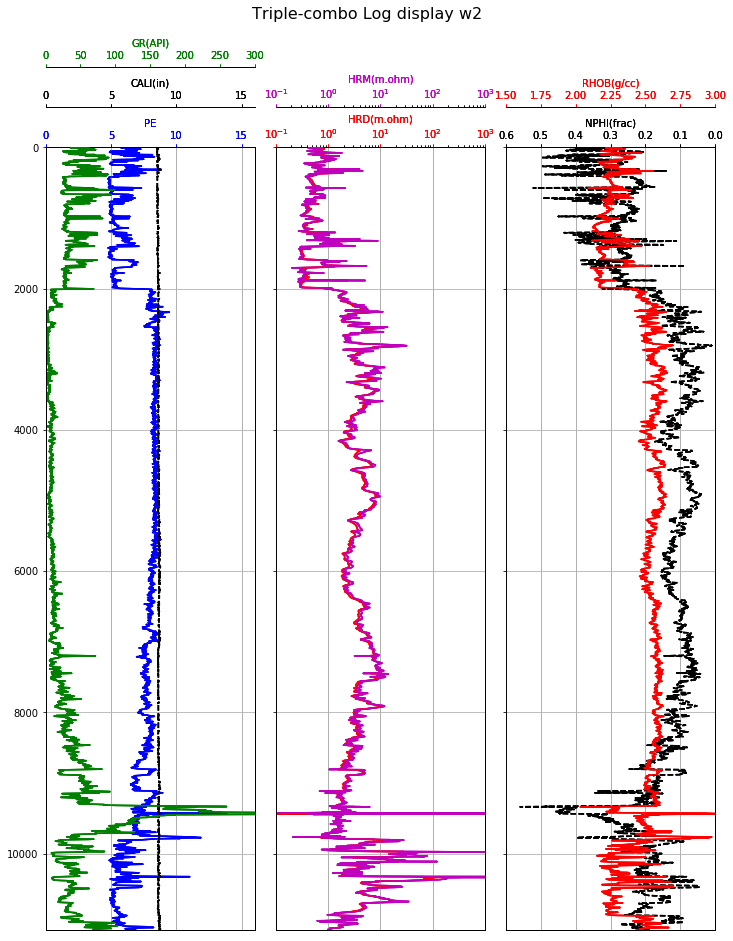

In [33]:
triple_combo_log1(w2,w2.index.min(),w2.index.max())

In [34]:
# check data columns of training and test data before merging as a single file for clustering
training_data.columns


Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS',
       'anomaly_isf'],
      dtype='object')

In [35]:
#rename w2 as test_data
test_data = w2.copy()

In [36]:
test_data.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN'], dtype='object')

In [37]:
# Add well column as Train and Test on each dataset
training_data['Well']= np.nan
training_data = training_data.replace(np.nan, 'Train')
test_data['Well']= np.nan
test_data = test_data.replace(np.nan, 'Test')

In [38]:
training_data.head(5)

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,anomaly_isf,Well
0,14.8824,0.5173,57.1903,1.9826,1.9726,27.9432,2.3510,125.9611,306.8676,1,Train
1,14.2318,0.4309,63.0144,2.0054,1.4613,19.5635,2.4219,125.7362,305.1737,1,Train
2,14.0163,0.4469,60.8421,1.9533,1.4438,9.8556,2.3138,125.9774,304.4476,1,Train
3,13.6321,0.4633,58.7762,1.8688,1.4327,6.6753,2.1849,126.5374,305.9166,1,Train
4,13.4571,0.4821,61.1278,1.7827,1.3871,6.6690,2.1394,127.0895,309.3540,1,Train


In [39]:
test_data.head(5)

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,Well
0,8.5781,0.3521,55.1824,0.8121,0.7810,6.8291,2.3256,Test
1,8.5781,0.3639,57.0114,0.8038,0.7723,6.8100,2.3255,Test
2,8.5781,0.3703,58.9263,0.7444,0.7048,6.7766,2.3212,Test
3,8.5625,0.3667,57.3308,0.7169,0.6542,6.7219,2.3119,Test
4,8.5781,0.3500,53.0624,0.6845,0.6109,6.6384,2.2982,Test


In [40]:
# combine train and test data for unsupervised clustering operation
data = training_data.append(test_data)

In [41]:
data.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,anomaly_isf
count,30381.000000,30381.000000,30381.000000,30381.000000,30381.000000,30381.000000,30381.000000,19293.000000,19293.000000,19293.0
mean,8.458278,0.204029,41.868671,3.088006,40.678266,4.949001,2.437615,87.212337,177.737553,1.0
std,1.399994,0.135387,50.715607,4.852791,1435.406597,3.846728,0.163417,22.815320,81.024963,0.0
min,5.930400,0.009800,0.852000,0.083900,0.102700,-0.023200,2.033400,53.477300,83.636800,1.0
25%,8.546900,0.104400,10.959100,0.939200,0.925700,0.055200,2.266400,70.201600,126.762600,1.0
50%,8.625000,0.158700,30.992600,2.315300,2.438800,5.797100,2.504900,78.629400,141.136700,1.0
75%,8.671900,0.260900,53.416600,3.793500,4.164600,8.083500,2.571100,99.595700,189.183900,1.0
max,21.064200,0.642300,1304.289800,202.233000,62290.769500,27.943200,3.024800,155.980300,487.438400,1.0


In [42]:
data.head(5)

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,anomaly_isf,Well
0,14.8824,0.5173,57.1903,1.9826,1.9726,27.9432,2.3510,125.9611,306.8676,1.0,Train
1,14.2318,0.4309,63.0144,2.0054,1.4613,19.5635,2.4219,125.7362,305.1737,1.0,Train
2,14.0163,0.4469,60.8421,1.9533,1.4438,9.8556,2.3138,125.9774,304.4476,1.0,Train
3,13.6321,0.4633,58.7762,1.8688,1.4327,6.6753,2.1849,126.5374,305.9166,1.0,Train
4,13.4571,0.4821,61.1278,1.7827,1.3871,6.6690,2.1394,127.0895,309.3540,1.0,Train


In [43]:
data.tail(5)

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,anomaly_isf,Well
11083,8.7813,0.1882,68.0333,1.0280,0.9815,6.5003,2.4423,NaN,NaN,NaN,Test
11084,8.7344,0.1879,68.0753,1.0249,0.9822,6.4415,2.4377,NaN,NaN,NaN,Test
11085,8.7266,0.1824,68.8516,1.0459,1.0199,6.3413,2.4342,NaN,NaN,NaN,Test
11086,8.7500,0.1822,70.8515,1.0609,1.0541,6.2254,2.4320,NaN,NaN,NaN,Test
11087,8.7500,0.1840,69.9109,1.0602,1.0453,6.1295,2.4313,NaN,NaN,NaN,Test


# Unsupervised Clustering

As from previous analyzing the wireline logs from training well, we decided to drop CAL, PE and HRM log for clustering operation. As two resitivity logs does not provide any additional information, we would like to keep only deep resistivity. PE log is poor quality in the more than 2/3rd of training data points. CAL log have relationship with sonic response in the formation. So, we will use GR, CNC, HRD and ZDEN log to group the dataset into cluster.

In [44]:
# drop features and saved under a new database
data1=data.drop(columns=[ 'Well','DTC', 'CAL', 'DTS','PE','HRM','anomaly_isf'], axis=1)

In [45]:
data1.describe()

,CNC,GR,HRD,ZDEN
count,30381.000000,30381.000000,30381.000000,30381.000000
mean,0.204029,41.868671,3.088006,2.437615
std,0.135387,50.715607,4.852791,0.163417
min,0.009800,0.852000,0.083900,2.033400
25%,0.104400,10.959100,0.939200,2.266400
50%,0.158700,30.992600,2.315300,2.504900
75%,0.260900,53.416600,3.793500,2.571100
max,0.642300,1304.289800,202.233000,3.024800


In [46]:
# feature transform
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data1)
data2 = scaler.transform(data1)

(array([8.4300e+02, 4.7370e+03, 3.7910e+03, 1.9770e+03, 6.1930e+03,
        1.1813e+04, 9.7900e+02, 1.4000e+01, 9.0000e+00, 2.5000e+01]),
 array([-2.47355879, -1.86687969, -1.26020059, -0.65352149, -0.04684239,
         0.55983671,  1.16651581,  1.77319491,  2.37987401,  2.98655311,
         3.59323221]),
 <a list of 10 Patch objects>)

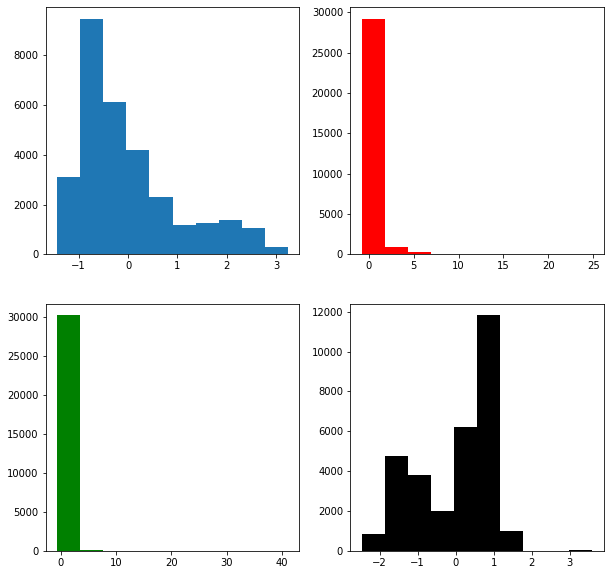

In [47]:
# histogram of transformed features
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.hist(data2[:,0])

plt.subplot(222)
plt.hist(data2[:,1],color='r')

plt.subplot(223)
plt.hist(data2[:,2],color='g')

plt.subplot(224)
plt.hist(data2[:,3],color='k')

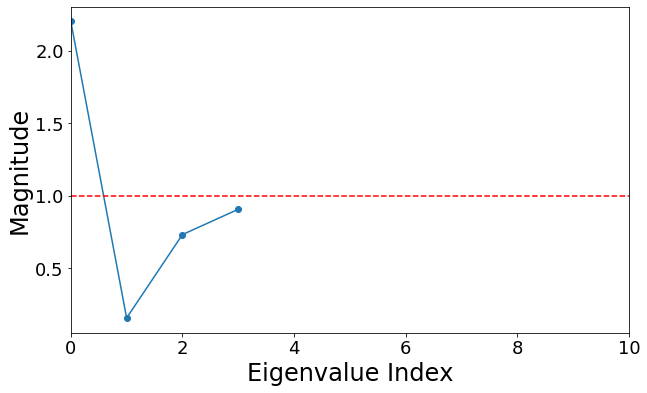

In [48]:
fig = plt.figure(figsize=(10,6))
covar_matrix = np.cov(data2, rowvar=False)
eigenvalues = np.linalg.eig(covar_matrix)[0]
plt.plot(eigenvalues, 'o-')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.tick_params(labelsize=18)
plt.xlabel('Eigenvalue Index', fontsize=24)
plt.ylabel('Magnitude', fontsize=24)
plt.xlim(0,10)
plt.xticks([0,2,4,6,8,10])
plt.show()

In [49]:
# Factor Analysis
fa_model = FactorAnalysis(n_components = 4)
fa_model.fit(data2)
factor_data = fa_model.transform(data2)

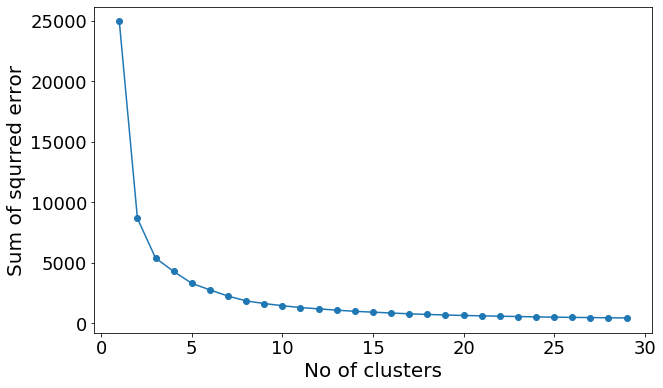

In [50]:
# KNN clustering , find out number of clusters
inertias = []
means=[]
maxK=30

for k in range(1, maxK):
    kmeans=KMeans(n_clusters=k, random_state=100).fit(factor_data)
    means.append(k)
    inertias.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(means, inertias, 'o-')
plt.ylabel('Sum of squrred error', fontsize=20)
plt.xlabel('No of clusters',fontsize=20)
plt.tick_params(labelsize=18)
plt.show()

From the above plot, we can see four clusters will be reasonable to find out the cluster group

In [51]:
# fit the features with four clusters
kmeans=KMeans(n_clusters=4, random_state=0)
kmeans.fit(factor_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [52]:
#cluster ids to database
data['Cluster']= kmeans.labels_

(array([5179.,    0.,    0., 6372.,    0.,    0., 3831.,    0.,    0.,
        3911.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

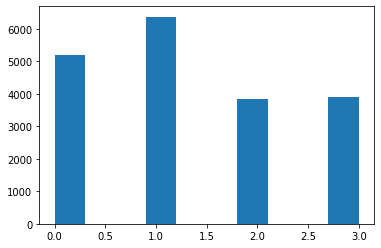

In [53]:
# histogram of training data cluster
plt.hist(data.Cluster[data.Well=='Train'])

(array([2704.,    0.,    0., 3884.,    0.,    0.,  283.,    0.,    0.,
        4217.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

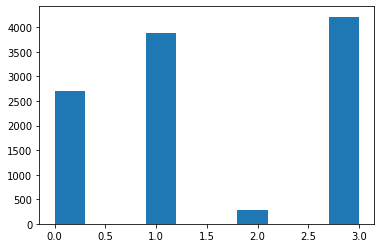

In [54]:
# histogram of test data cluster
plt.hist(data.Cluster[data.Well=='Test'])

In [55]:
facies_colors = sns.color_palette("Set1", 4)

In [56]:
def make_facies_log_plot(logs, facies_colors, label):
    # reset to original matplotlib style
    # seaborn doesn't look as good for this
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    #make sure logs are sorted by depth 
    #logs = logs.sort_values(by='index')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.index.min(); zbot=logs.index.max()
    
    cluster=np.repeat(np.expand_dims(logs[label].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
    ax[0].plot(logs.GR, logs.index, '-g')
    ax[1].plot(logs['HRD'], logs.index, '-')
    ax[2].plot(logs['ZDEN'], logs.index, '-', color='r')
    ax[3].plot(logs['CNC'], logs.index, '-', color='k')
    im=ax[4].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=4)
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((20*' ').join(['Cluster1', 'Cluster2', 'Cluster3','Cluster4'
                                ]), fontsize=12)
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel('GR', fontsize=12)
    ax[0].set_xlim(0,250)
    ax[0].set_ylabel('Sample', fontsize=16)
    ax[0].tick_params(labelsize=12)
    ax[0].grid(b=False)
    ax[1].set_xlabel("HRD (ohm-m)", fontsize=12)
    ax[1].set_xlim(0,50)
    ax[1].grid(b=False)
    ax[1].tick_params(labelsize=12)
    ax[2].set_xlabel("RHOB[g/cc]", fontsize=12)
    ax[2].set_xlim(1.5,3)
    ax[2].grid(b=False)
    ax[2].tick_params(labelsize=12)
    ax[3].set_xlabel("CNC", fontsize=12)
    ax[3].set_xlim(0,1)
    ax[3].grid(b=False)
    ax[3].tick_params(labelsize=12)
    ax[4].set_xlabel('Facies', fontsize=16)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[4].set_xticklabels([])
    
    return f

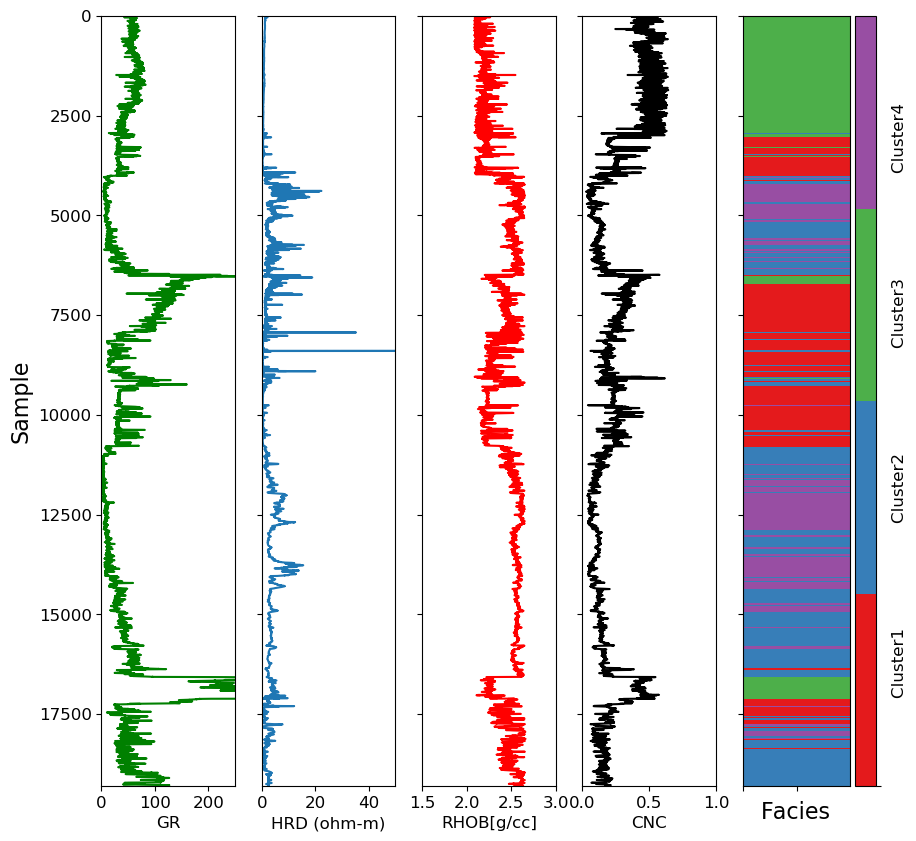

In [57]:
#training data cluster log
make_facies_log_plot(data[data.Well=='Train'],facies_colors, label='Cluster')
plt.show()

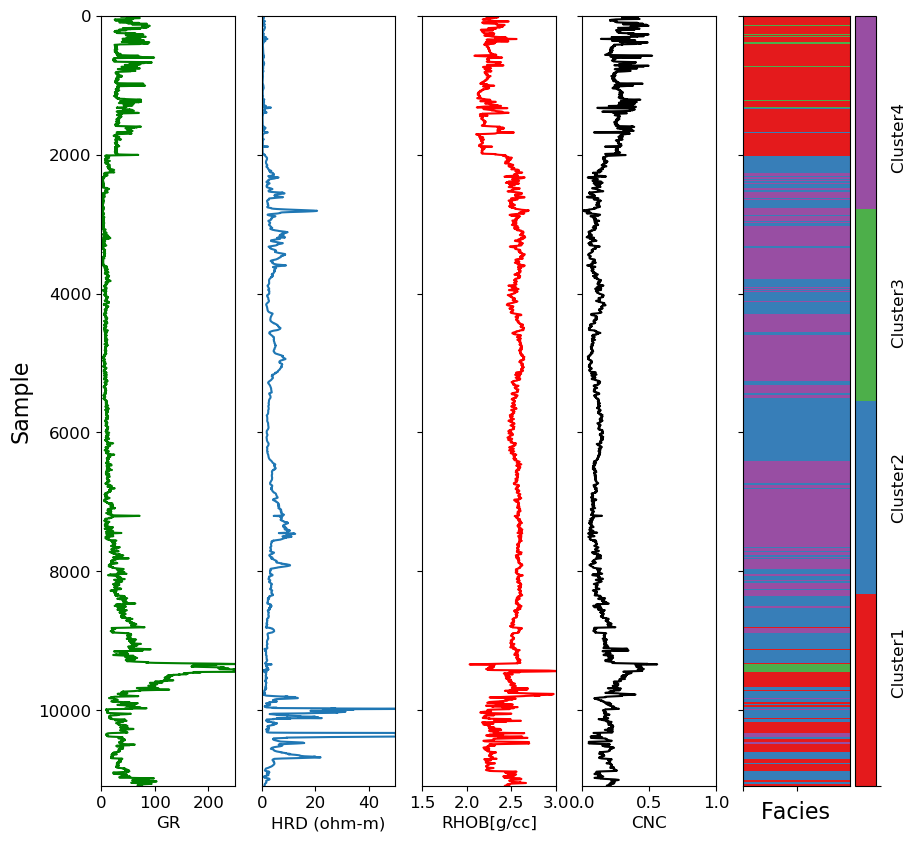

In [58]:
# Test well cluster plot
make_facies_log_plot(data[data.Well=='Test'],facies_colors, label='Cluster')
plt.show()

In [59]:
# drop the anomaly flag column from the combined data
data=data.drop(columns=['anomaly_isf'],axis=1)

# Modelling and Prediction

In [60]:
# seperate training from the combined data
train_data = data[data.Well == 'Train']
train_data.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Cluster
count,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000,19293.000000
mean,8.357259,0.230194,49.283807,2.547563,2.704499,3.567083,2.415621,87.212337,177.737553,1.335562
std,1.748542,0.148991,52.960473,2.551030,6.722277,4.145705,0.167015,22.815320,81.024963,1.079505
min,5.930400,0.026400,1.038900,0.123600,0.134100,-0.023200,2.083700,53.477300,83.636800,0.000000
25%,6.633100,0.118900,15.331200,0.819500,0.804300,0.049400,2.242900,70.201600,126.762600,0.000000
50%,8.578100,0.181500,36.748500,1.932100,1.941100,0.069100,2.470300,78.629400,141.136700,1.000000
75%,8.625000,0.306000,60.723200,3.370700,3.496700,6.869900,2.562100,99.595700,189.183900,2.000000
max,21.064200,0.642300,1304.289800,89.479200,637.878300,27.943200,2.661100,155.980300,487.438400,3.000000


In [61]:
# drop well column
train_data = train_data.drop(columns=['Well'], axis = 1)

In [62]:
# split train_data into subsets based on clusters
cluster0_train = train_data[train_data.Cluster == 0]
cluster0_train.reset_index(drop=True, inplace=True)
cluster1_train = train_data[train_data.Cluster == 1]
cluster1_train.reset_index(drop=True, inplace=True)
cluster2_train = train_data[train_data.Cluster == 2]
cluster2_train.reset_index(drop=True, inplace=True)
cluster3_train = train_data[train_data.Cluster == 3]
cluster3_train.reset_index(drop=True, inplace=True)

In [63]:
cluster0_train.index, cluster1_train.index,cluster2_train.index,cluster3_train.index

(RangeIndex(start=0, stop=5179, step=1),
 RangeIndex(start=0, stop=6372, step=1),
 RangeIndex(start=0, stop=3831, step=1),
 RangeIndex(start=0, stop=3911, step=1))

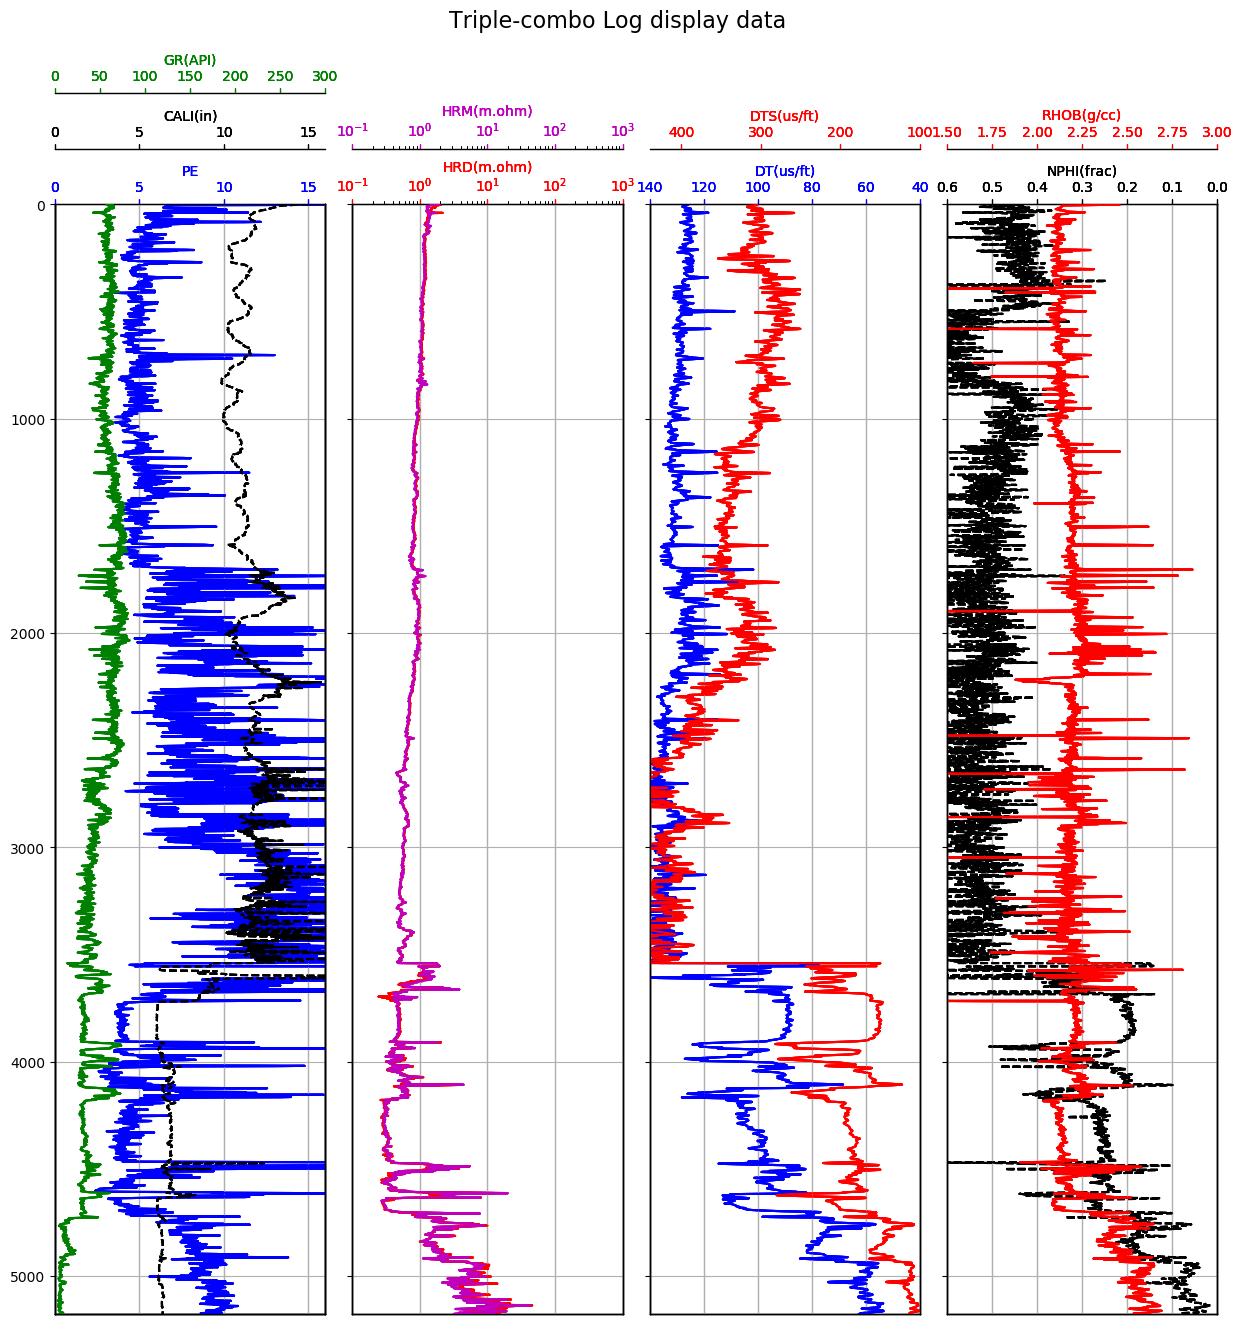

In [64]:
#display triple combo log based on cluster
triple_combo_log(cluster0_train, cluster0_train.index.min(), cluster0_train.index.max())

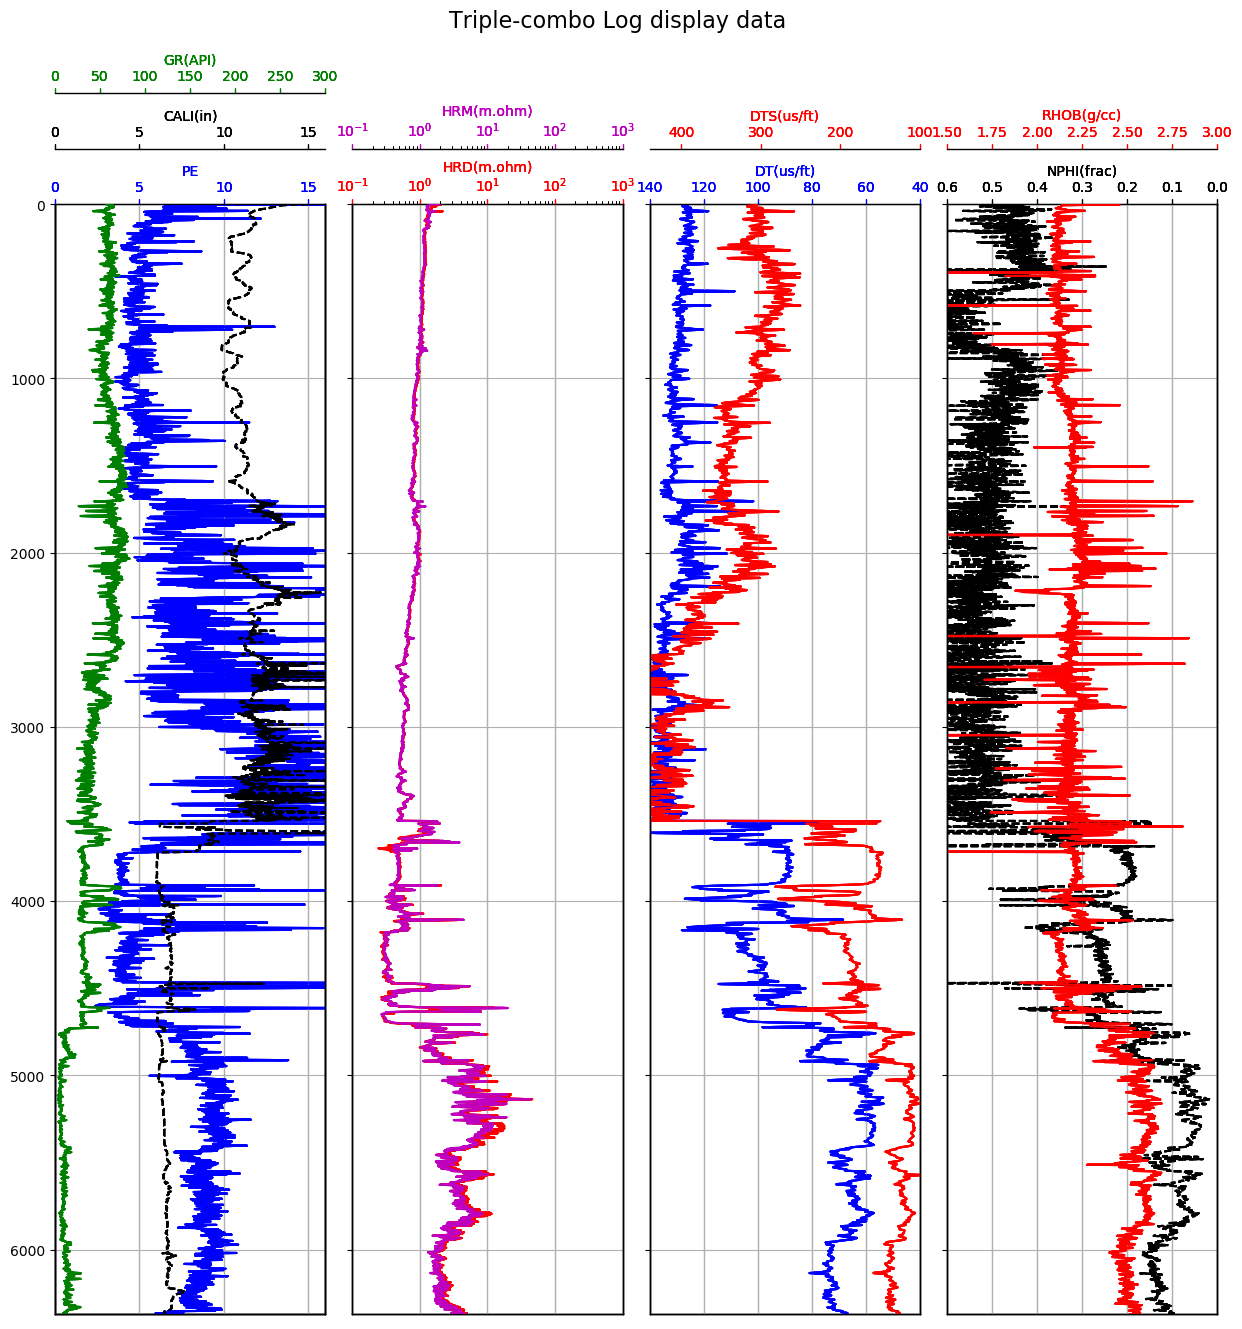

In [65]:
triple_combo_log(cluster1_train, cluster1_train.index.min(), cluster1_train.index.max())

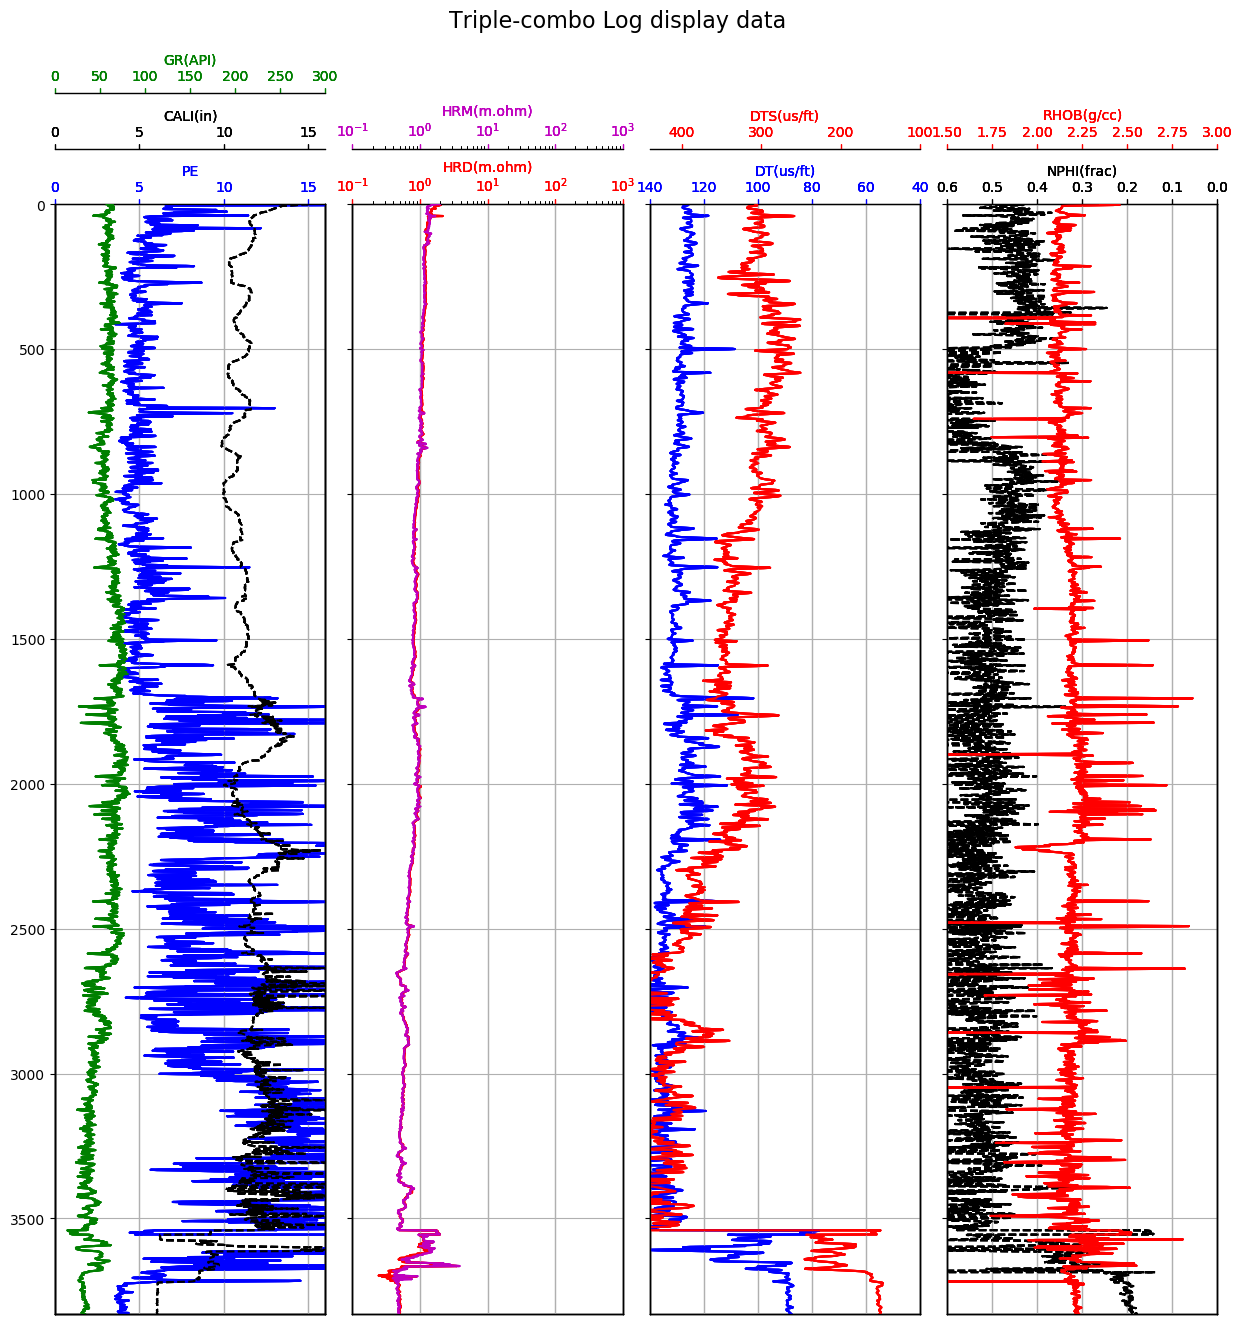

In [66]:
triple_combo_log(cluster2_train, cluster2_train.index.min(), cluster2_train.index.max())

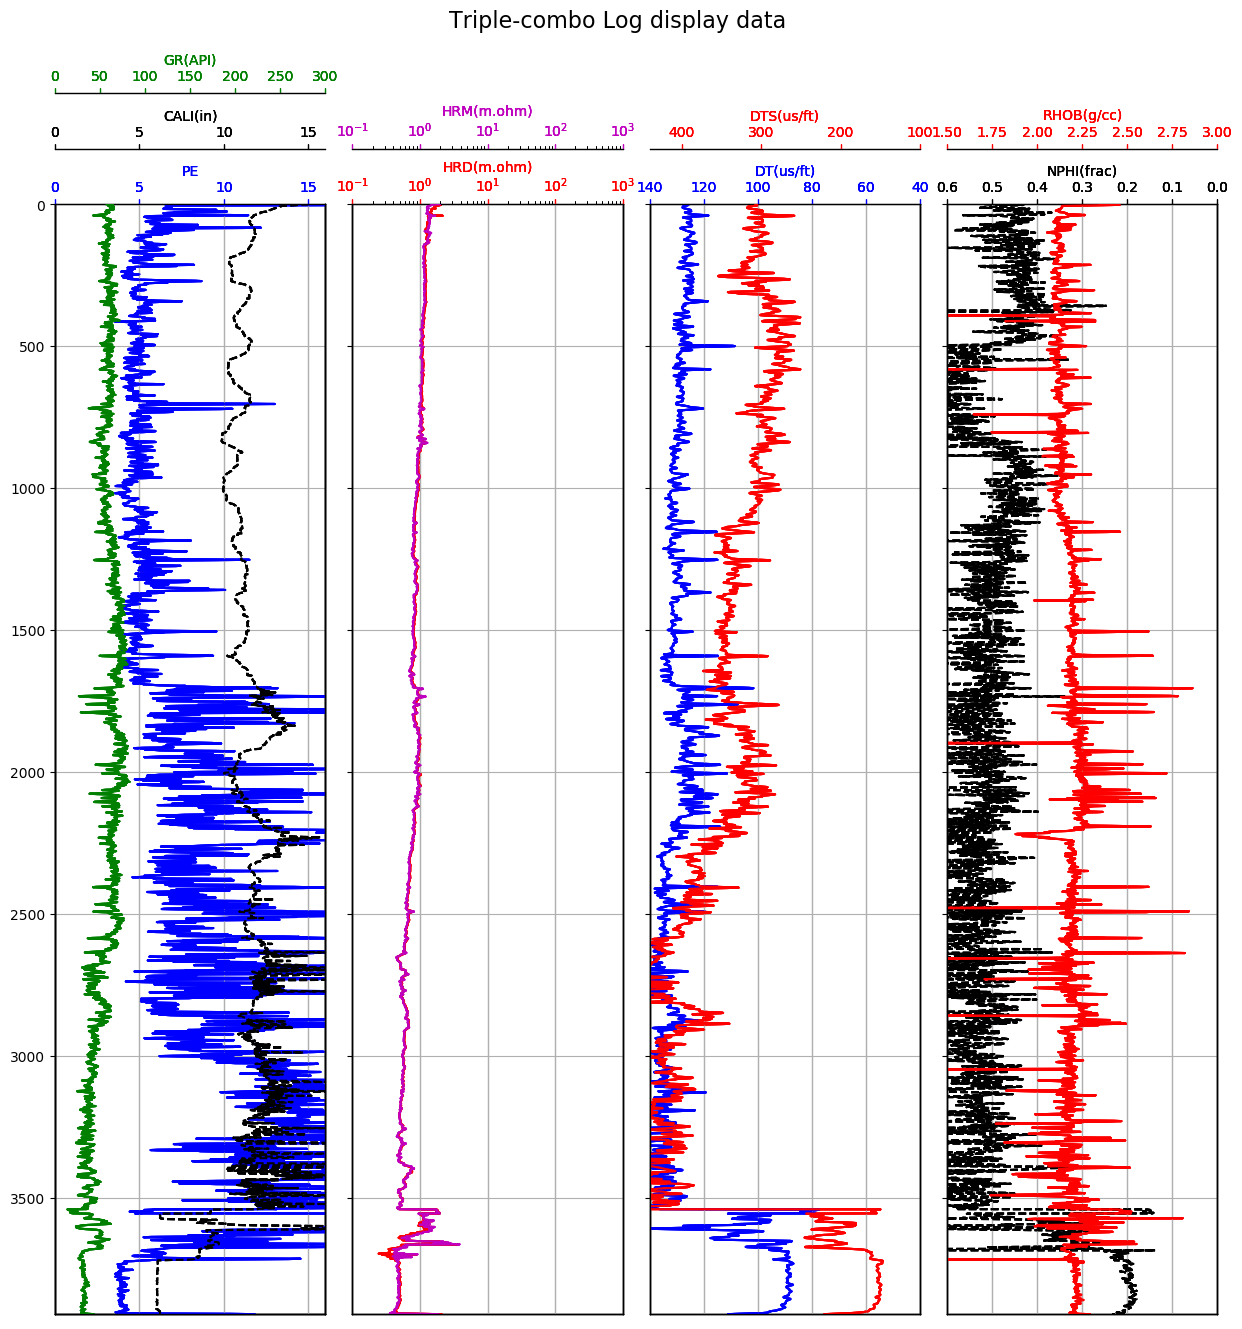

In [67]:
triple_combo_log(cluster3_train, cluster3_train.index.min(), cluster3_train.index.max())

In [68]:
# import sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [69]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real['DTC'])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real['DTS'])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real['DTC'], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real['DTS'], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')
    plt.show()

training cluster 0


In [70]:
cluster0_train.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Cluster
count,5179.000000,5179.000000,5179.000000,5179.000000,5179.000000,5179.000000,5179.000000,5179.000000,5179.000000,5179.0
mean,7.323167,0.254121,56.953276,0.928416,1.270944,3.765803,2.311722,92.033523,171.450710,0.0
std,1.219923,0.053926,38.507371,0.890926,10.030385,3.551577,0.115916,9.485417,28.207752,0.0
min,5.930400,0.123200,8.425800,0.153600,0.199100,0.000000,2.099800,65.059900,111.135900,0.0
25%,6.294700,0.213800,30.809100,0.374850,0.377000,0.054100,2.218900,85.521050,151.375400,0.0
50%,6.800800,0.247900,37.072200,0.558900,0.549200,4.168500,2.285300,90.840800,175.214200,0.0
75%,8.546900,0.289900,90.318200,1.326700,1.329450,6.233500,2.421750,98.077900,187.755900,0.0
max,21.064200,0.468500,207.420300,15.090900,637.878300,25.346700,2.600600,140.745400,439.474600,0.0


In [71]:
# seperate the features and targets
cluster0_train = cluster0_train.drop(columns = ['CAL','PE'], axis = 1)
features0 = cluster0_train[cluster0_train.columns[:-3]]
targets0 = cluster0_train[cluster0_train.columns[-3:-1]]
# standize the matrix for training data
scaler0 = StandardScaler()
feature_vectors0 = scaler0.fit_transform(features0)

In [72]:
#Train_Test_Splitting
X_train0, X_test0, y_train0, y_test0 = train_test_split(feature_vectors0, targets0, test_size=0.2, random_state=100)

Training data cluster0 r2-score is: 0.93631
Training data cluster0 Root Mean Square Error is: 5.52363


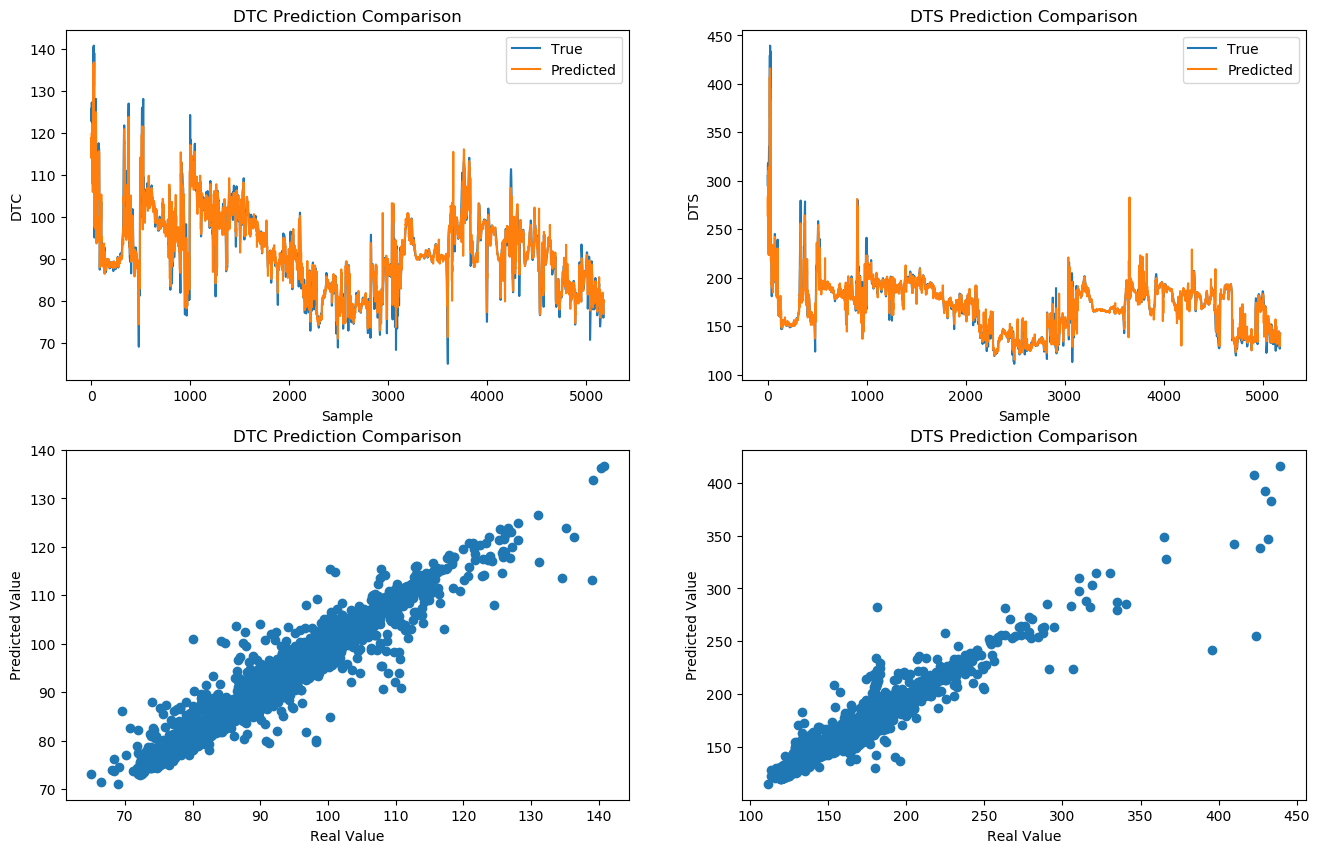

In [73]:
model0 = RandomForestRegressor(n_estimators=100, random_state=100)
model0 = GridSearchCV(estimator=model0, param_grid={}, scoring='r2', cv=5).fit(X_train0, y_train0)
model0_pred = model0.predict(feature_vectors0)
print('Training data cluster0 r2-score is:', '{:.5f}'.format(r2_score(targets0, model0_pred)))
print('Training data cluster0 Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(targets0, model0_pred))))
result_plot(model0_pred, targets0)

In [74]:
# validation data cluster0
pred0 = model0.predict(X_test0)
score0 = r2_score(y_test0, pred0)
rme0 = np.sqrt(mean_squared_error(y_test0, pred0))
print('Cluster0 Validation data R2 and RMSE values are:',score0, rme0)

Validation data R2 and RMSE values are: 0.7927705835602747 9.6408514833457


Training cluster1

In [75]:
cluster1_train.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Cluster
count,6372.000000,6372.000000,6372.000000,6372.000000,6372.000000,6372.000000,6372.000000,6372.000000,6372.000000,6372.0
mean,8.059886,0.149266,36.506084,2.381531,2.534861,2.158964,2.520722,74.199544,135.647323,1.0
std,0.980191,0.031211,25.328446,0.997064,1.445804,3.580154,0.059377,5.155419,13.400018,0.0
min,5.962100,0.069400,1.038900,0.239200,0.224000,0.009400,2.212100,59.420100,97.763000,1.0
25%,6.916775,0.125700,13.357750,1.794500,1.793975,0.047900,2.488400,70.967375,128.300925,1.0
50%,8.625000,0.143700,36.185600,2.418250,2.462450,0.054600,2.528200,73.664250,134.542650,1.0
75%,8.625000,0.169000,50.041950,2.936100,3.113900,5.179350,2.561725,76.715150,140.609925,1.0
max,17.312300,0.301600,131.517800,20.078300,38.679000,17.631900,2.653200,133.678800,430.171300,1.0


In [76]:
# seperate the features and targets
cluster1_train = cluster1_train.drop(columns = ['CAL','PE'], axis = 1)
features1 = cluster1_train[cluster1_train.columns[:-3]]
targets1 = cluster1_train[cluster1_train.columns[-3:-1]]
# standize the matrix for training data
scaler1 = StandardScaler()
feature_vectors1 = scaler1.fit_transform(features1)

In [77]:
#Train_Test_Splitting
X_train1, X_test1, y_train1, y_test1 = train_test_split(feature_vectors1, targets1, test_size=0.2, random_state=100)

Training data cluster1 r2-score is: 0.86710
Training data cluster1 Root Mean Square Error is: 3.91803


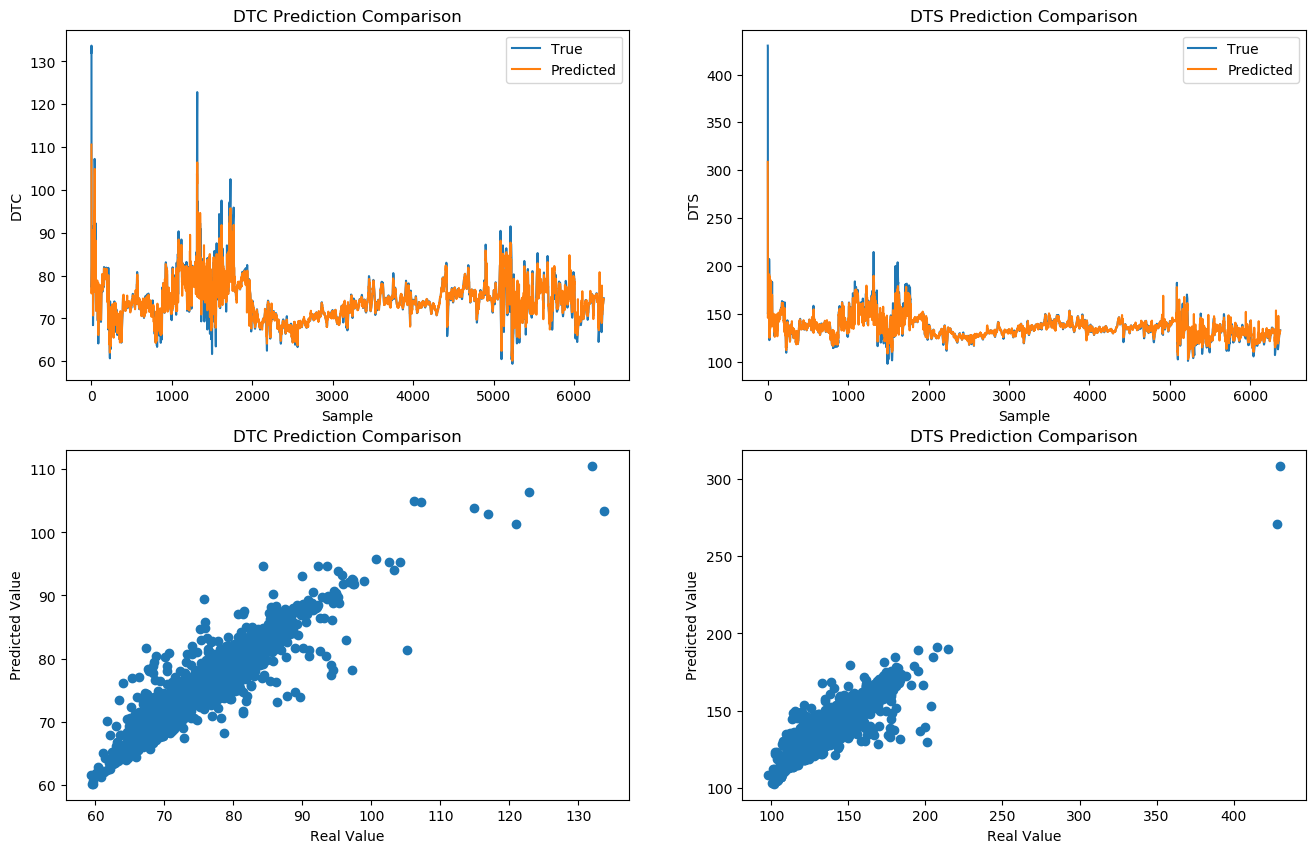

In [78]:
model1 = RandomForestRegressor(n_estimators=100, random_state=100)
model1 = GridSearchCV(estimator=model1, param_grid={}, scoring='r2', cv=5).fit(X_train1, y_train1)
model1_pred = model1.predict(feature_vectors1)
print('Training data cluster1 r2-score is:', '{:.5f}'.format(r2_score(targets1, model1_pred)))
print('Training data cluster1 Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(targets1, model1_pred))))
result_plot(model1_pred, targets1)

In [79]:
pred1 = model1.predict(X_test1)
score1 = r2_score(y_test1, pred1)
rme1 = np.sqrt(mean_squared_error(y_test1, pred1))
print('Cluster1 Validation data R2 and RMSE values are:', score1, rme1)

Cluster1 Validation data R2 and RMSE values are: 0.6229880235013301 7.087968510135629


training cluster2

In [80]:
cluster2_train.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Cluster
count,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.0
mean,10.675952,0.488215,96.196670,1.551214,1.562340,6.525674,2.200354,125.666314,316.412019,2.0
std,1.904590,0.061750,84.316366,1.554645,1.762734,4.327006,0.064267,10.672595,76.395919,0.0
min,6.092300,0.308300,23.980800,0.123600,0.134100,-0.023200,2.083700,82.361400,160.478500,2.0
25%,9.996900,0.441600,54.854900,0.683500,0.676050,4.584350,2.154600,122.252700,266.009750,2.0
50%,11.102400,0.487600,63.633100,0.901800,0.883100,5.839900,2.195000,128.748000,318.805900,2.0
75%,11.771950,0.534800,75.075450,1.221800,1.194300,8.240700,2.241200,132.581300,375.056250,2.0
max,20.353200,0.642300,1304.289800,18.910900,35.042700,27.943200,2.536600,155.980300,487.438400,2.0


In [81]:
# seperate the features and targets, in this cluster we keep all input features 
features2 = cluster2_train[cluster2_train.columns[:-3]]
targets2 = cluster2_train[cluster2_train.columns[-3:-1]]
# standize the matrix for training data
scaler2 = StandardScaler()
feature_vectors2 = scaler2.fit_transform(features2)

In [82]:
#Train_Test_Splitting
X_train2, X_test2, y_train2, y_test2 = train_test_split(feature_vectors2, targets2, test_size=0.2, random_state=100)

Training data cluster2 r2-score is: 0.98533
Training data cluster2 Root Mean Square Error is: 4.42666


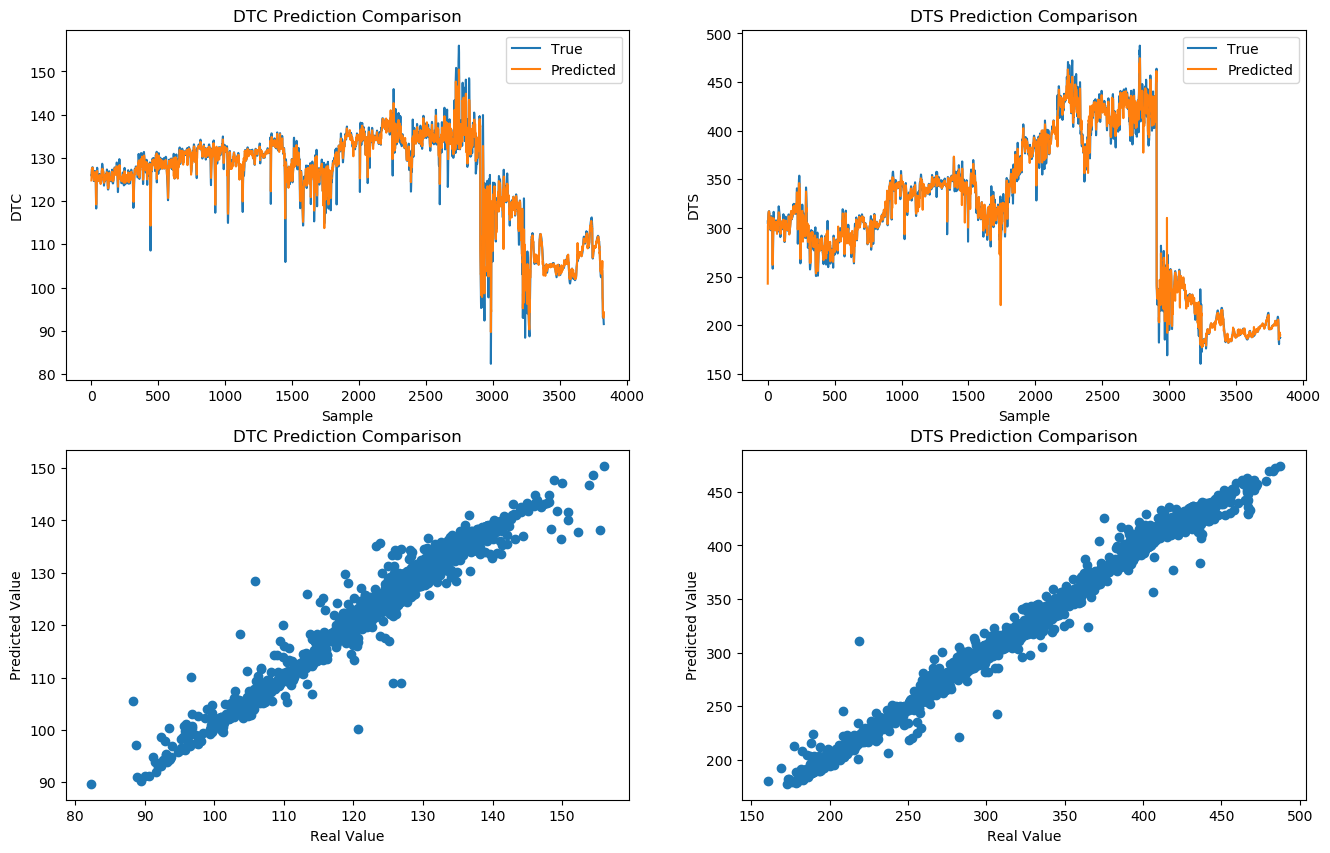

In [83]:
model2 = RandomForestRegressor(n_estimators=100, random_state=100)
model2 = GridSearchCV(estimator=model2, param_grid={}, scoring='r2', cv=5).fit(X_train2, y_train2)
model2_pred = model2.predict(feature_vectors2)
print('Training data cluster2 r2-score is:', '{:.5f}'.format(r2_score(targets2, model2_pred)))
print('Training data cluster2 Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(targets2, model2_pred))))
result_plot(model2_pred, targets2)

In [84]:
pred2 = model2.predict(X_test2)
score2 = r2_score(y_test2, pred2)
rme2 = np.sqrt(mean_squared_error(y_test2, pred2))
print('Cluster2 Validation data R2 and RMSE values are:',score2, rme2)

Cluster2 Validation data R2 and RMSE values are: 0.9555036016458662 7.612774179699039


training cluster3

In [85]:
cluster3_train.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Cluster
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.0
mean,7.939848,0.077619,13.992653,5.938134,5.998012,2.700044,2.592832,64.361764,118.800353,3.0
std,0.996579,0.020157,10.957345,3.328945,8.269265,4.032261,0.030484,4.056713,8.533702,0.0
min,5.981300,0.026400,1.708100,0.911800,0.761000,0.016300,2.484700,53.477300,83.636800,3.0
25%,6.627150,0.061000,6.676650,3.917750,3.908200,0.047000,2.571150,61.362650,112.871900,3.0
50%,8.578100,0.078100,9.690900,5.036200,5.156600,0.051800,2.594500,64.160800,118.267700,3.0
75%,8.601600,0.094200,18.683550,7.247150,6.924450,7.770750,2.616100,67.039750,123.507900,3.0
max,8.703100,0.149800,80.536000,89.479200,460.627400,13.811000,2.661100,118.902600,164.075100,3.0


In [86]:
# seperate the features and targets
cluster3_train = cluster3_train.drop(columns = ['CAL','PE'], axis = 1)
features3 = cluster3_train[cluster3_train.columns[:-3]]
targets3 = cluster3_train[cluster3_train.columns[-3:-1]]
# standize the matrix for training data
scaler3 = StandardScaler()
feature_vectors3 = scaler3.fit_transform(features3)

In [87]:
#Train_Test_Splitting
X_train3, X_test3, y_train3, y_test3 = train_test_split(feature_vectors3, targets3, test_size=0.2, random_state=100)

Training data cluster3 r2-score is: 0.94147
Training data cluster3 Root Mean Square Error is: 1.64199


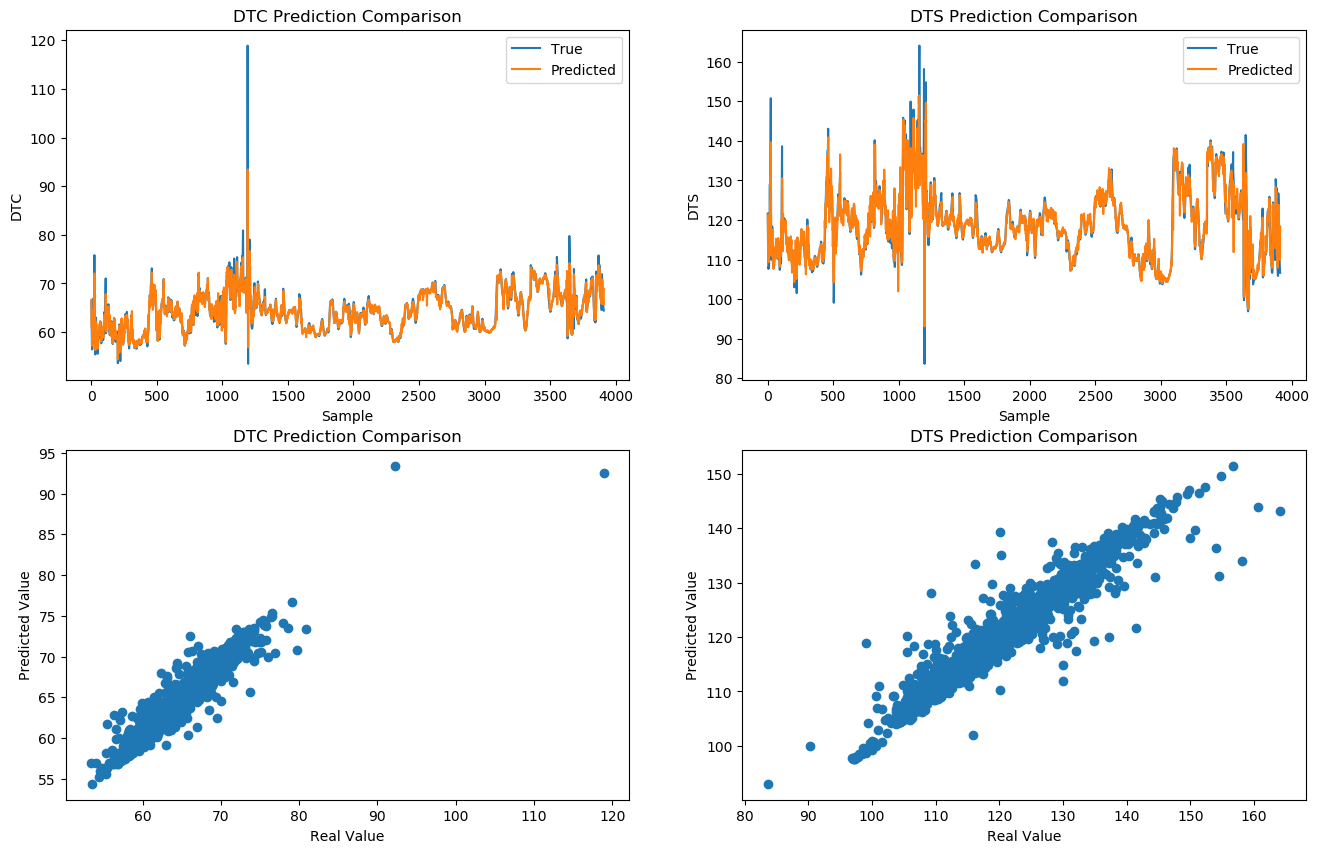

In [88]:
model3 = RandomForestRegressor(n_estimators=100, random_state=100)
model3 = GridSearchCV(estimator=model3, param_grid={}, scoring='r2', cv=5).fit(X_train3, y_train3)
model3_pred = model3.predict(feature_vectors3)
print('Training data cluster3 r2-score is:', '{:.5f}'.format(r2_score(targets3, model3_pred)))
print('Training data cluster3 Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(targets3, model3_pred))))
result_plot(model3_pred, targets3)

In [89]:
pred3 = model3.predict(X_test3)
score3 = r2_score(y_test3, pred3)
rme3 = np.sqrt(mean_squared_error(y_test3, pred3))
print('Cluster3 Validation data R2 and RMSE values are:',score3, rme3)

Cluster3 Validation data R2 and RMSE values are: 0.8339342858262719 2.873303216772432


# Predictions on blind well

In [90]:
test_data = data[data.Well == 'Test']
test_data.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Cluster
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,0.0,0.0,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884,NaN,NaN,1.542298
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440,NaN,NaN,1.223406
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400,NaN,NaN,0.000000
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175,NaN,NaN,1.000000
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600,NaN,NaN,1.000000
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800,NaN,NaN,3.000000
max,8.875000,0.559400,1124.442000,202.233000,62290.769500,13.840700,3.024800,NaN,NaN,3.000000


In [91]:
test_data.head(10)

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Well,Cluster
0,8.5781,0.3521,55.1824,0.8121,0.7810,6.8291,2.3256,NaN,NaN,Test,0
1,8.5781,0.3639,57.0114,0.8038,0.7723,6.8100,2.3255,NaN,NaN,Test,0
2,8.5781,0.3703,58.9263,0.7444,0.7048,6.7766,2.3212,NaN,NaN,Test,0
3,8.5625,0.3667,57.3308,0.7169,0.6542,6.7219,2.3119,NaN,NaN,Test,0
4,8.5781,0.3500,53.0624,0.6845,0.6109,6.6384,2.2982,NaN,NaN,Test,0
5,8.5781,0.3292,48.6237,0.6335,0.5528,6.5230,2.2817,NaN,NaN,Test,0
6,8.5781,0.3088,43.2046,0.6041,0.5062,6.3724,2.2648,NaN,NaN,Test,0
7,8.5781,0.2946,39.2762,0.5779,0.4961,6.1726,2.2484,NaN,NaN,Test,0
8,8.5625,0.2927,38.0329,0.5532,0.4731,5.9497,2.2337,NaN,NaN,Test,0
9,8.5469,0.3021,35.7902,0.5411,0.4493,5.7830,2.2211,NaN,NaN,Test,0


In [92]:
test_data = test_data.drop(columns=['Well', 'DTC', 'DTS'], axis = 1)
test_data.dropna(axis=0, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [93]:
# split test_data into subsets based on clusters

# cluster 0
cluster0_test = test_data[test_data.Cluster == 0]
cluster0_test = cluster0_test.drop(columns=['CAL','PE','Cluster'], axis = 1)
#cluster0_test.reset_index(drop=True, inplace=True)

# cluster 1
cluster1_test = test_data[test_data.Cluster == 1]
cluster1_test = cluster1_test.drop(columns=['CAL','PE','Cluster'], axis = 1)
#cluster1_test.reset_index(drop=True, inplace=True)

# cluster 2
cluster2_test = test_data[test_data.Cluster == 2]
cluster2_test = cluster2_test.drop(columns=['Cluster'], axis = 1)
#cluster2_test.reset_index(drop=True, inplace=True)

# cluster 3
cluster3_test = test_data[test_data.Cluster == 3]
cluster3_test = cluster3_test.drop(columns=['CAL','PE','Cluster'], axis = 1)
#cluster3_test.reset_index(drop=True, inplace=True)

In [94]:
cluster0_test.describe(),cluster1_test.describe(),cluster2_test.describe(),cluster3_test.describe(),

(               CNC           GR          HRD          HRM         ZDEN
 count  2704.000000  2704.000000  2704.000000  2704.000000  2704.000000
 mean      0.266198    47.268609     1.361423     1.458271     2.273399
 std       0.053334    27.836920     1.493157     1.719481     0.106039
 min       0.149700    10.509400     0.257500     0.202700     2.106200
 25%       0.225975    29.079725     0.422450     0.381675     2.195475
 50%       0.260600    35.171450     0.725000     0.724250     2.243000
 75%       0.293875    54.263950     1.560600     1.608950     2.328925
 max       0.454300   209.300300    10.863600    12.646700     2.613800,
                CNC           GR          HRD          HRM         ZDEN
 count  3884.000000  3884.000000  3884.000000  3884.000000  3884.000000
 mean      0.147504    24.933910     3.267533     4.066957     2.508793
 std       0.035347    20.785223     3.924362     7.943043     0.081639
 min       0.074100     1.173600     0.390300     0.211000     

In [95]:
# transform and run predition for each cluster
scaled_cluster0 = scaler0.transform(cluster0_test)
pred_cluster0 = model0.predict(scaled_cluster0)
pred_cluster0 = pd.DataFrame({'DTC':pred_cluster0[:,0], 'DTS':pred_cluster0[:,1]}, index = cluster0_test.index)

scaled_cluster1 = scaler1.transform(cluster1_test)
pred_cluster1 = model1.predict(scaled_cluster1)
pred_cluster1 = pd.DataFrame({'DTC':pred_cluster1[:,0], 'DTS':pred_cluster1[:,1]}, index = cluster1_test.index)

scaled_cluster2 = scaler2.transform(cluster2_test)
pred_cluster2 = model2.predict(scaled_cluster2)
pred_cluster2 = pd.DataFrame({'DTC':pred_cluster2[:,0], 'DTS':pred_cluster2[:,1]}, index = cluster2_test.index)

scaled_cluster3 = scaler3.transform(cluster3_test)
pred_cluster3 = model3.predict(scaled_cluster3)
pred_cluster3 = pd.DataFrame({'DTC':pred_cluster3[:,0], 'DTS':pred_cluster3[:,1]}, index = cluster3_test.index)

In [96]:
#1merged all predicted clusters
merged_predictions = pd.concat([pred_cluster0, pred_cluster1, pred_cluster2, pred_cluster3])
merged_predictions.sort_index(inplace=True)
merged_predictions.head(10)

,DTC,DTS
0,99.725945,203.421784
1,101.827320,202.143602
2,104.067114,209.066516
3,106.598906,214.296919
4,107.317198,211.313266
5,111.733011,223.067588
6,100.584849,189.821254
7,100.268074,196.904914
8,99.765232,195.616072
9,100.898256,193.037230


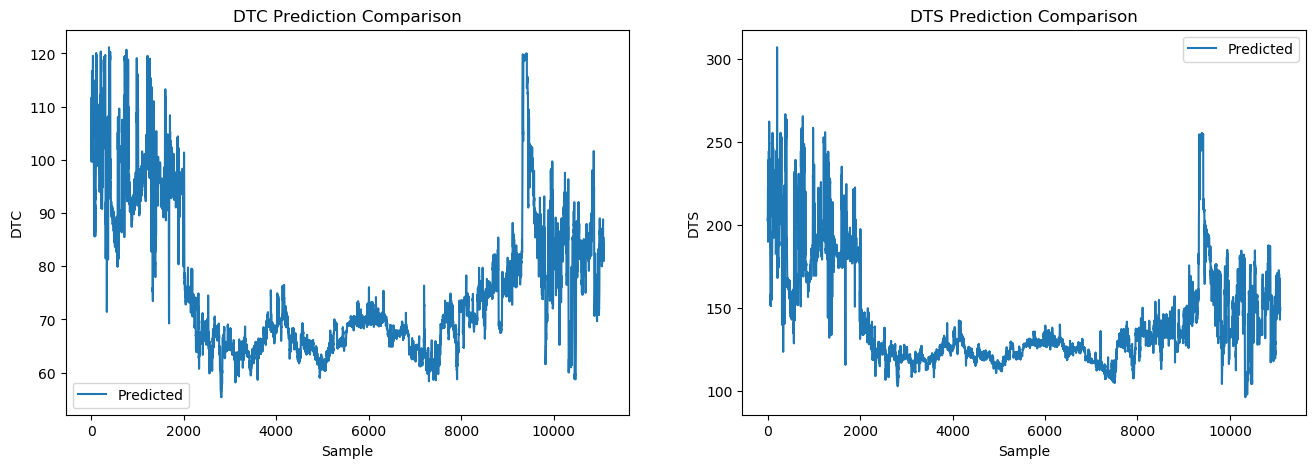

In [97]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(merged_predictions['DTC'])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(merged_predictions['DTS'])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

Prediction output

In [98]:
#output_result.to_csv(path_or_buf='./sample_submission.csv', index=False)
merged_predictions.to_csv('./Data3_1_2020/MLogging_submission_final_update.csv', index=False)